# IMA204 Practical Session - Segmentation of medical images



# Introduction

Images to use are provided in a zip file called **data.zip** to install in your local directory from where you are running this notebook.

The goal of this practical session is to push K-means segmentation method as a pre-segmentation tool on different types of medical images: CT scans for the segmentation of kidneys and tumors, MRI for the corpus callosum in the brain , temporal sequences of MRI images for segmentation of the myocardium.

You are provided with pre-processing ideas. 
You will have to adjust a pipeline for **AT LEAST** one application (kidney/tumor, corpus callosum or heart).

You have to submit your code and comment your results. 

**Deadline**: You will have to upload a single jupyter notebook .ipynb with your answers (code + text) before the deadline (please check on Ecampus/Moodle). 

**The uploaded file should be named 'TP_SegMedImage_YOURSURNAME.ipynb'.** 

**RUN THE WHOLE NOTEBOOK FIRST TO GET A FULL OVERVIEW OF USE-CASES AND THE NOTION OF HYPERPARAMETERS.**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For listing files in local foler
import glob

# For loading .mat files
from scipy.io import loadmat

import skimage
from skimage.io import imread
from skimage import morphology
from skimage.segmentation import watershed 
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from scipy import ndimage
from skimage.measure import find_contours
import skimage.morphology as morpho  
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage.filters import gaussian
from skimage.segmentation import morphological_geodesic_active_contour

# For Kmeans
import cv2 


Working_directory = os.getcwd()
print('Working_directory = ',Working_directory)

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Working_directory =  c:\Users\lmcastanedame\OneDrive - Universidad Nacional de Colombia\MANUELA\TÉLÉCOM\IMA\IMA204\TPs\TP4 - Medical Image Segmentation\IMA204---TP3-Medical-Segmentation


In [3]:
def my_kmeans(image, k):
    # k = number of clusters
    
    # Reshaping the image  
    pixel_vals = image.reshape((-1,1)) 

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria   = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) #criteria
    retval, labels, centers = cv2.kmeans(pixel_vals, k, 
                None, criteria, 10, cv2.KMEANS_PP_CENTERS) 
    centers = np.uint8(centers) # convert data into 8-bit values 
    # print(centers)
    
    segmented_data   = centers[labels.flatten()] # Mapping labels to center points( RGB Value)
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape)) # reshape data into the original image dimensions
    
    return segmented_image, segmented_labels


def my_colormap_white_bkg(Colormap_name,numLabels):
    #numLabels = number of colors
    
    Colormap  = plt.get_cmap(Colormap_name, numLabels)
    newcolors = Colormap(np.linspace(0, 1, numLabels))
    bkg_color = np.array([256/256, 256/256, 256/256, 1])
    max_color = np.array([0/256, 0/256, 0/256, 1])
    newcolors[numLabels-1, :] = max_color
    newcolors[0, :] = bkg_color
    newcmp = ListedColormap(newcolors)
    return newcmp

## Abdominal CT 

You have at your disposal **6 abdominal CT scans** of different subjects. Subjects may have renal tumor. You also have the manual segmentations for both kidney and, when present, the tumor. 

Variables defined: <br>
* abdominalCT_path
* listImagesabdCT
* Img_abdo_ex
* Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

There are 6 abdomical CT images
Reading image  c:\Users\lmcastanedame\OneDrive - Universidad Nacional de Colombia\MANUELA\TÉLÉCOM\IMA\IMA204\TPs\TP4 - Medical Image Segmentation\IMA204---TP3-Medical-Segmentation/data/abdominalCT\CTs1.tiff
[  0 127 255]


Text(0.5, 1.0, 'Image +contour tumor')

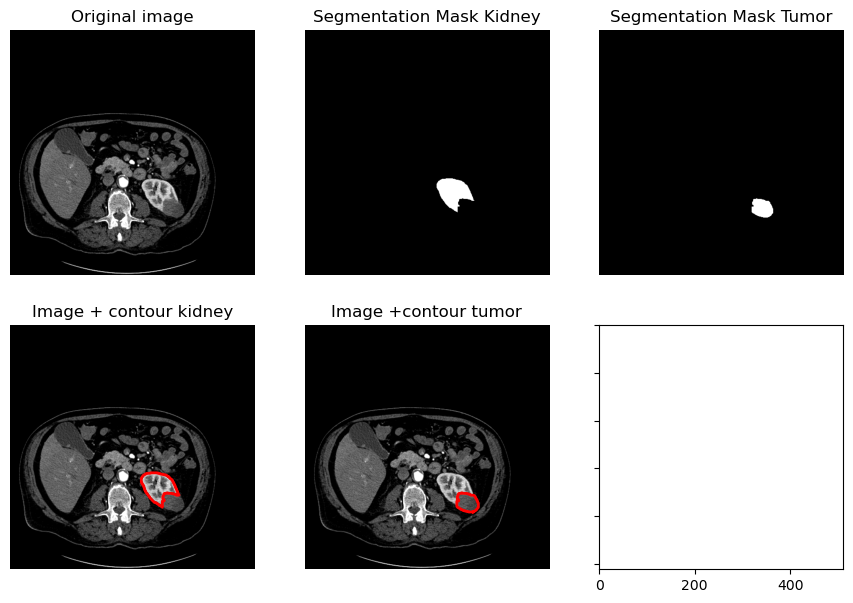

In [4]:
abdominalCT_path = Working_directory + '/data/abdominalCT'  
os.listdir(abdominalCT_path)
listImagesabdCT=glob.glob(abdominalCT_path + '/*-seg.tiff')
print('There are', len(listImagesabdCT),  'abdomical CT images')

# Choose a figure and plot it with the ground truth segmentation
indexIm=0 # between 0 and 5

# Abdominal CT
filename_Segmentation = listImagesabdCT[indexIm]
Labels_abdo_ex   = imread(filename_Segmentation)
filename         = filename_Segmentation[:-9] + '.tiff'
Img_abdo_ex      = imread(filename) 

print('Reading image ', filename)
print(np.unique(Labels_abdo_ex))

if Img_abdo_ex.shape != Labels_abdo_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Labels_abdo_ex we may have two values: 127 is for kidney and 255 for renal tumor
Seg_abdo_kidney_ex=Labels_abdo_ex==127
if np.sum(Seg_abdo_kidney_ex)==0:
  print('There is no kidney')
Cont_abdo_kidney_ex = find_contours(Seg_abdo_kidney_ex, 0.5)

Seg_abdo_tumor_ex=Labels_abdo_ex==255
if np.sum(Seg_abdo_tumor_ex)==0:
  print('There is no tumor')
Cont_abdo_tumor_ex = find_contours(Seg_abdo_tumor_ex, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_abdo_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(Seg_abdo_kidney_ex,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask Kidney")
grid[2].imshow(Seg_abdo_tumor_ex,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Segmentation Mask Tumor")
grid[3].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_kidney_ex:
  grid[3].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[3].axis('off')
grid[3].set_title("Image + contour kidney")
grid[4].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_tumor_ex:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[4].axis('off')
grid[4].set_title("Image +contour tumor")


# Brain MRI

Here you can select medial slices of the brain of **4 different subjects**. You also have manual segmentations of the corpus callosum.

Variables defined: <br>
* brainMRI_path
* listImagesbrainMRI
* Seg_brain_ex
* Img_brain_ex

There are 4 brain MRI images
['c:\\Users\\lmcastanedame\\OneDrive - Universidad Nacional de Colombia\\MANUELA\\TÉLÉCOM\\IMA\\IMA204\\TPs\\TP4 - Medical Image Segmentation\\IMA204---TP3-Medical-Segmentation/data/brainMRI\\MRIs1-seg.png', 'c:\\Users\\lmcastanedame\\OneDrive - Universidad Nacional de Colombia\\MANUELA\\TÉLÉCOM\\IMA\\IMA204\\TPs\\TP4 - Medical Image Segmentation\\IMA204---TP3-Medical-Segmentation/data/brainMRI\\MRIs2-seg.png', 'c:\\Users\\lmcastanedame\\OneDrive - Universidad Nacional de Colombia\\MANUELA\\TÉLÉCOM\\IMA\\IMA204\\TPs\\TP4 - Medical Image Segmentation\\IMA204---TP3-Medical-Segmentation/data/brainMRI\\MRIs3-seg.png', 'c:\\Users\\lmcastanedame\\OneDrive - Universidad Nacional de Colombia\\MANUELA\\TÉLÉCOM\\IMA\\IMA204\\TPs\\TP4 - Medical Image Segmentation\\IMA204---TP3-Medical-Segmentation/data/brainMRI\\MRIs4-seg.png']
Reading image  c:\Users\lmcastanedame\OneDrive - Universidad Nacional de Colombia\MANUELA\TÉLÉCOM\IMA\IMA204\TPs\TP4 - Medical Image Segmentat

Text(0.5, 1.0, 'Image with segmentation\n corpus callosum')

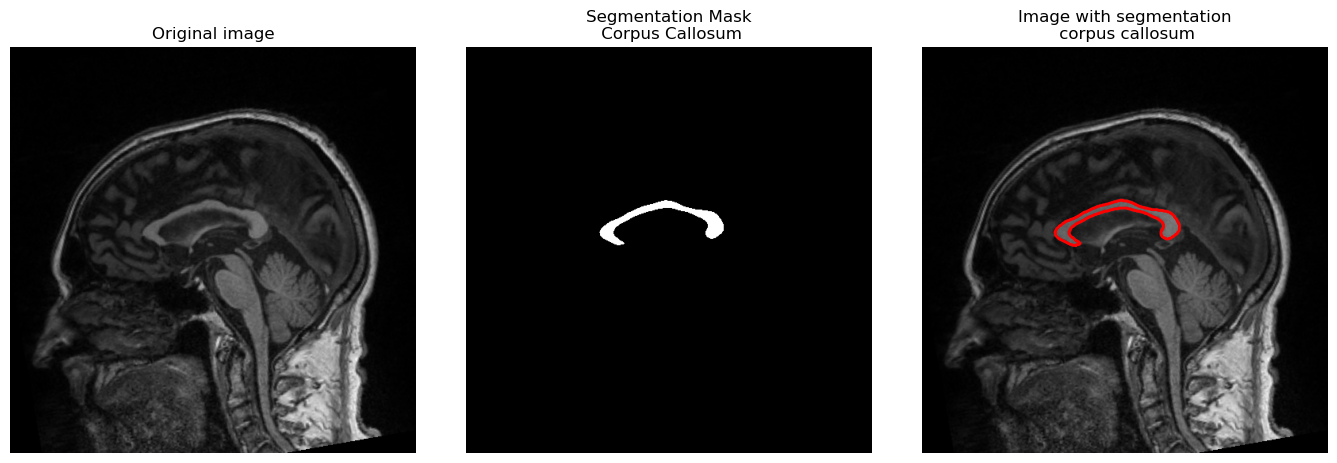

In [5]:
brainMRI_path = Working_directory + '/data/brainMRI'
os.listdir(brainMRI_path)
listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

# Choose a brain MRI and plot it with the ground truth segmentation
indexIm      = 3 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename) 

print('Reading image ', filename)

if Img_brain_ex.shape != Seg_brain_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Im Seg we have masks of the corpus callosum
maskCC      = Seg_brain_ex==255
contourMask = find_contours(maskCC, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_brain_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskCC,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask\n Corpus Callosum");
grid[2].imshow(Img_brain_ex, cmap='gray')
for contour in contourMask:
  grid[2].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[2].axis('off')
grid[2].set_title("Image with segmentation\n corpus callosum")


# Preliminaries

## Mathematical Morphology

Incitations to use morphological operators seen during the previous lectures to segment the provided images. 


Think about the structural elements and the hyper-parameters ... We typically adapt their values to the image resolution and type of structures targeted in our segmentation (eg. brigth or dark).



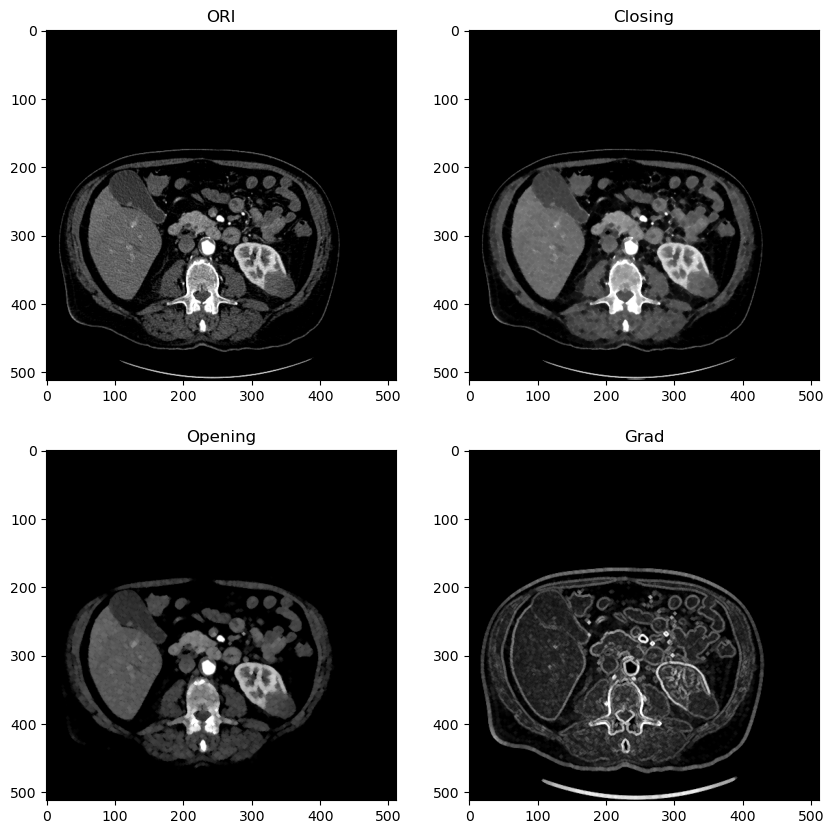

In [6]:
#Select input image
# Img_test         = Img_cardiac_ex
# Img_test         = Img_brain_ex
Img_test         = Img_abdo_ex ; # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

# Define Element
Radius           = 2
se               = disk(Radius)

# Morpho closing
Img_test_close  = morpho.closing(Img_test,se)

# Morpho Opening
Img_test_open    = morpho.opening(Img_test,se)

# Morpho Gradient
Img_test_grad  = morpho.dilation(Img_test,se)-morpho.erosion(Img_test,se)


#Figure display
fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Img_test_close,cmap='gray')
ax[1].set_title("Closing")
ax[2].imshow(Img_test_open,cmap='gray')
ax[2].set_title("Opening")
ax[3].imshow(Img_test_grad,cmap='gray')
ax[3].set_title("Grad")

plt.show()

## Regular filtering

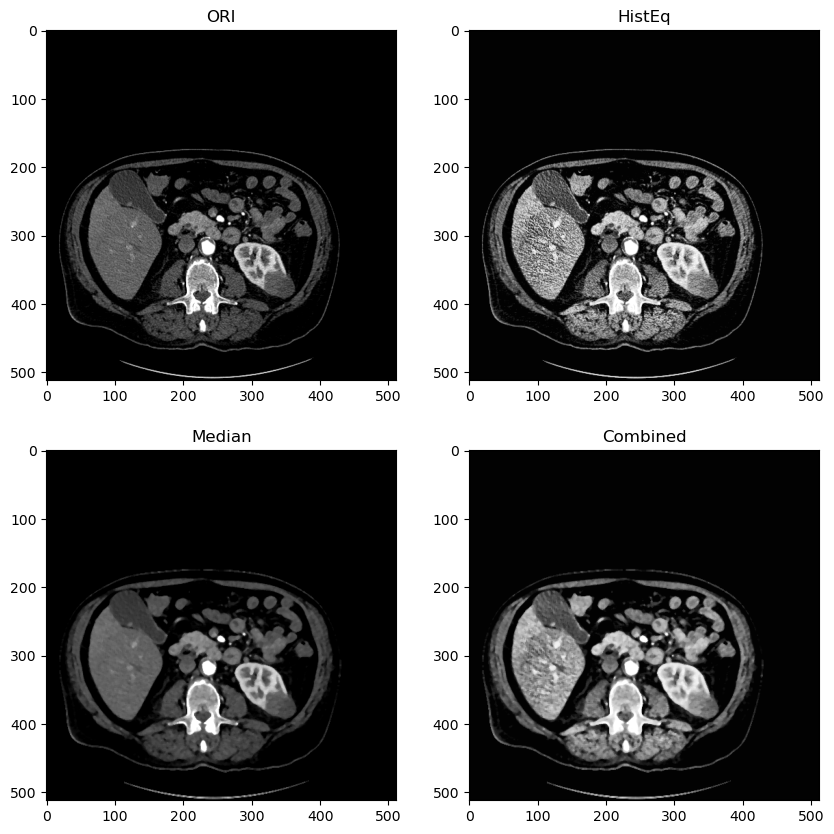

In [7]:
img_histeq    = skimage.exposure.equalize_adapthist(Img_test, clip_limit=0.03)
img_median    = ndimage.median_filter(Img_test, size=4)
img_histeqmed = ndimage.median_filter(img_histeq, size=4)

fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(img_histeq,cmap='gray')
ax[1].set_title("HistEq")
ax[2].imshow(img_median,cmap='gray')
ax[2].set_title("Median")
ax[3].imshow(img_histeqmed,cmap='gray')
ax[3].set_title("Combined");

# ASSIGNMENT:

**Question** 
Develop a segmentation pipeline building upon **kmeans** as proposed below for **at least one application** and report quality of segmentation results comparing your results to the provided ground truth on multiple images.

We want you to focus on **pre-processing** your image AND **post process** your segmentation result to extract **THE structure of interest**. For the postprocessing you can rely on extraction of connected components and apply to criteria (size, shape, position,..) to extract the composant that most likely corresponds to the structure of interest. 


When processing medical images, and given that you are provided with several ground-truth (gt) segmentations you can push the exercice to consider: <br>
* Cropping the field of view to remove the background (a common issue in medical images)
* Target a range of intensity values based on learning from the gt masks and corresponding images 
* Learn priors on shape/intensity statistics from the provided gt masks


## Kmeans routine to segment your images

Kmeans is very often used as pre-segmentation to initialise a finer segmentation.

Provides a segmentation of the image using k-means clustering.
Be careful: Kmeans uses random initialisation and is therefore different at each run and randomly assigns  labels to clusters (0,1,2,...,K).

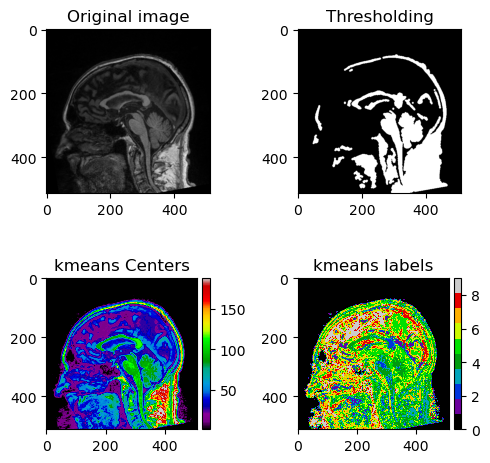

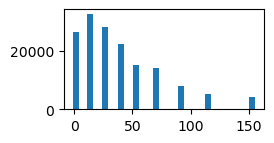

Your Target_value =  97
Distance of your Target_value to Centers =  [95 44 18 92  5 70 27 56 57 83]
Your selected label (starting with 0)=  4


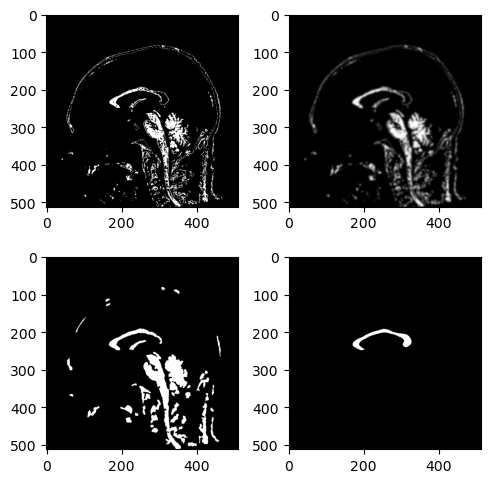

In [8]:
# Image use-case and HYPER-PARAMETER values provided as a good start

# Img_test         = Img_abdo_ex ; Img_seg_gt       = Seg_abdo_kidney_ex # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex
# nber_clusters    = 10; Target_value_thresh = 180 # For cardiac image
# Img_test            = Img_cardiac_ex; Img_seg_gt       = Seg_cardiac_ex
# nber_clusters       = 10; Target_value_thresh = 150 # For abdo image
Img_test          = Img_brain_ex ; Img_seg_gt       = Seg_brain_ex
nber_clusters     = 10; Target_value_thresh = 50 # For brain image


# [1] Example of segmentation via simple threshold 
# Compute a mask thresholding above target value
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh, 
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')


# [2] Example of segmentation via kmeans 
Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Display results
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_thresh, cmap='gray')
ax[1].set_title('Thresholding')

tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')

tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')

fig.tight_layout()
plt.show();

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_test, Img_label_mask)
    Img_label_means[i] = tmp[0]
#print(Img_label_means)

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(), 
                                         bins=Bins)
bar_width = 5
fig       = plt.figure(figsize=(2, 1))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_test, Seg_thresh)
Target_value = Target_value[0]
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
print('Your Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2, 
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[3].imshow(Img_seg_gt, cmap='gray')

fig.tight_layout()
plt.show()

## From Kmeans to Connected Components

This is an example on how to exploit the results from Kmeans.
Note that this example uses several hard-coded **hyperparameters** which is not appropriate to segment robustly several cases. 

If you reuse this piece of code for the question below, propose some approaches to set some of the hyperparameter values automatically (eg using the known average size of the structure of interest from the gt segmentation you have)

Max value in labels =  21
Number of connected components =  22


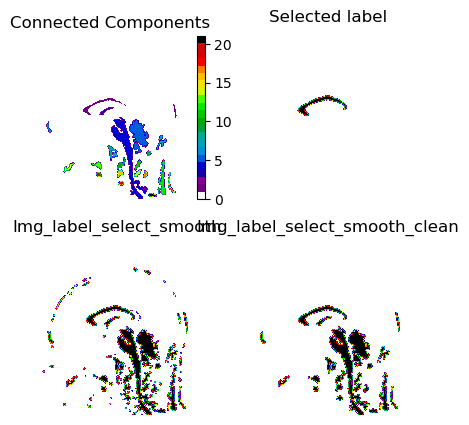

In [9]:
Img_label_select_filter = gaussian(Img_label_select, 2, 
                            preserve_range=True)
Img_label_select_smooth = Img_label_select_filter>0.25
Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth, min_size=150,connectivity=1),
    area_threshold=150)

# Extract connected components
Thresh = Img_label_select_smooth_clean
output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
(numLabels, labels, stats, centroids) = output
print('Max value in labels = ',labels.max())
print('Number of connected components = ',numLabels)

# Extract 1 connected component
thresh = labels==1

# plots results
Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

tmp     = ax[0].imshow(labels, cmap=Colormap)
divider   = make_axes_locatable(ax[0])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Connected Components')
ax[0].axis('off')
fig.colorbar(tmp, cax=cax, orientation='vertical')

ax[1].imshow(thresh, cmap=Colormap)
ax[1].set_title('Selected label')
ax[1].axis('off')
ax[2].imshow(Img_label_select_smooth, cmap=Colormap)
ax[2].set_title('Img_label_select_smooth')
ax[2].axis('off')
ax[3].imshow(Img_label_select_smooth_clean, cmap=Colormap)
ax[3].set_title('Img_label_select_smooth_clean');
ax[3].axis('off');

# Implement your full segmentation pipeline

## TO DO:

* Implement a full pipeline to segment TWO EXAMPLES from a single use case. Your code must run over the two cases in a loop. We need to be able to run the code without any adjustment to local path to access the input data. <br>
* Implement and compute a quality metric (eg Dice, overlap, relative area differences, errors between max diameters (something used to measure tumors), distances between contours) that compares your final segmentation with the ground-truth.
* Extra point if you provide results on more use-cases or more than 2 examples per use case. <br>
* Feel free to also test your segmentation pipeline on images degraded by noise for example. <br>
* Your final solution can involve registration or active contours from previous lectures. Just make sure to include the required functions and imports in your final notebook.<br>

### If you use the cardiac MRI dataset:
* Extra point because extra difficulties to load and prepare the data. <br>
* In this case the data preparation is part of your code below as you can only rely on the input data provided as it is.  <br>
* Use any slice from any case you want as your "learning" ground truths on which you can learn object size or shape characteristics for example. <br>
* Test your segmentation on any slice from any case, as long as the slices were not part of your "learning" ground-truth. <br>
* See if you can get your solution to not detect anything on slices that don't contain the left ventricle myocardium. <br>


### Important instructions:
* You cannot use the ground truth of the images you segment to segment them! But you can use the ground-truths of other examples of the same use-case to learn a priori knowledge such as size or average pixel intensity.<br>
* List all your hard-coded hyperparameters at the beginning of your code, indicating a variable name and its value. You will be penalised if you leave any hard-coded hyperparameter values inside your code. <br>

Nb: Dice = np.sum([seg==gt])*2.0/(np.sum(seg)+np.sum(gt)) #seg is the segmentation and gt is the ground truth. Both are of same size

#### Cardiac MRI 

The last section is about MRI sequences of the heart. 
You are provided with **a single use case**. 
Your goal is to segment the left ventricule. Be careful, the segmentation is not a maks but a series of points (landmarks). To obtain a binary mask, you should first interpolate the points (using for instance a spline). <br> 

The structure of this image data is more complex and needs some coding to load single slices to segment.


Variables defined: <br>
* MRIheart_path
* Img_cardiac_ex
* Seg_cardiac_ex


* Your final solution can involve registration or active contours from previous lectures. Just make sure to include the required functions and imports in your final notebook.<br>

For cardiac MRI: how to create a binary mask from the provided contours

MRI volume of the heart composed of 11 slices along the z axis and 20 temporal frames. Each slice is an image  256  x  256
For each slice and at each time frame we have a manual segmentation composed of 65 2D landmarks
Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value: [[-99999]]


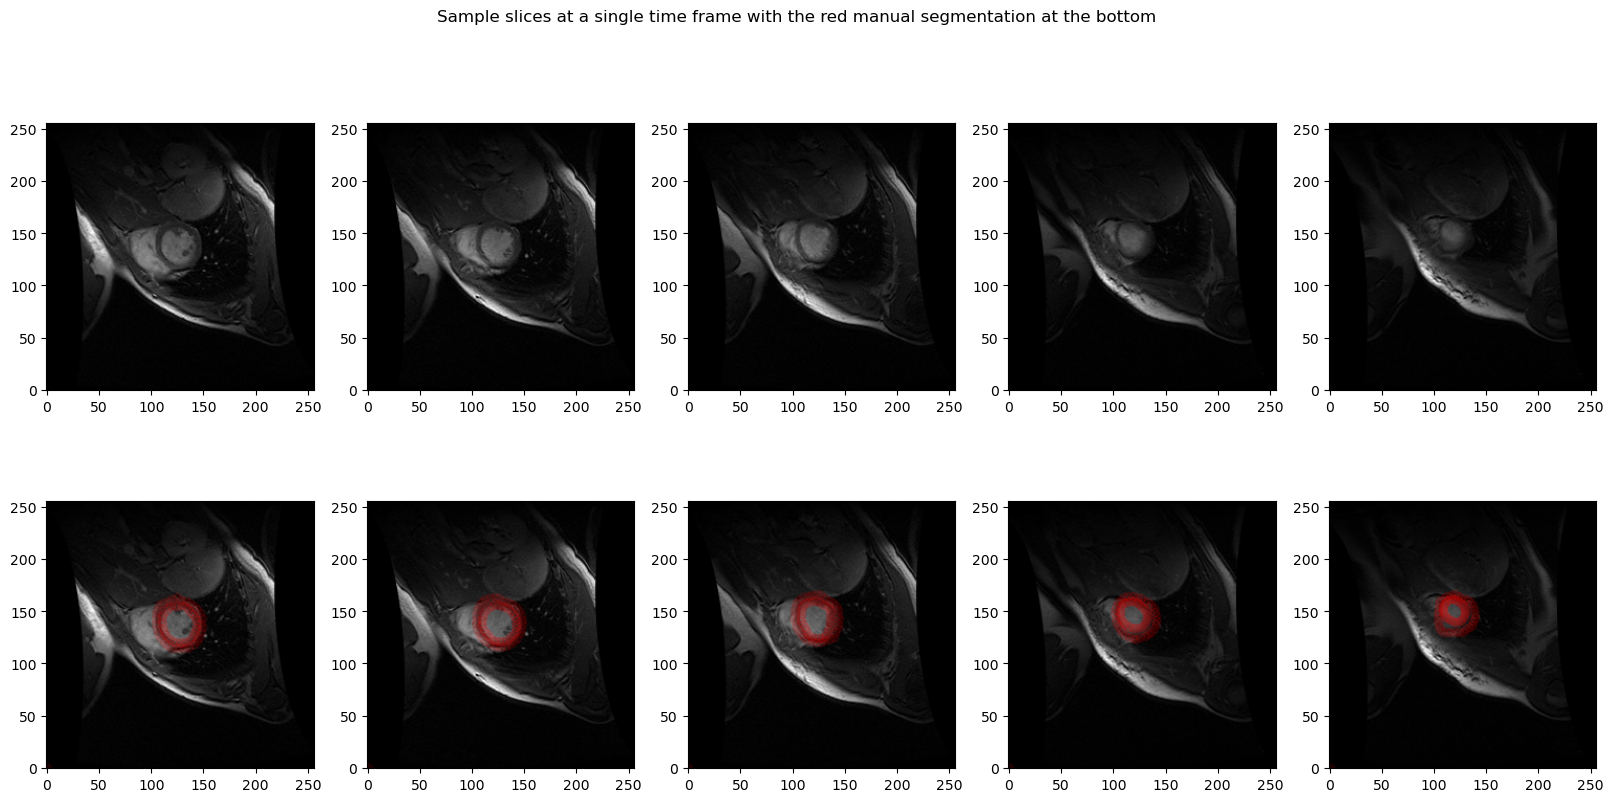

In [10]:
# Read one case
MRIheart_path = Working_directory + '/data/MRIheart/'
os.listdir(MRIheart_path)
data          = loadmat(MRIheart_path + 'dataMRIheart.mat')
data          = data['data']
seg           = loadmat(MRIheart_path + 'segMRIheart.mat')
seg           = seg['seg']

Ex_index_select = 6
Img_cardiac_ex = data[:,:,Ex_index_select,1] # can be index 4,5,6,...
Cont_cardiac_ex = seg[Ex_index_select,1][:]

print('MRI volume of the heart composed of', data.shape[2], 'slices along the z axis and', data.shape[3], 
'temporal frames. Each slice is an image ', data.shape[0], ' x ',  data.shape[1])
print('For each slice and at each time frame we have a manual segmentation composed of',seg[4,4].shape[0] , '2D landmarks')

print('Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value:', seg[0,0] )

plt.figure(figsize=(20, 9))
plt.suptitle('Sample slices at a single time frame with the red manual segmentation at the bottom')
plt.subplot(2, 5, 1)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 2)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 3)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 4)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 5)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 6)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[4,1][:,0], seg[4,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 7)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[5,1][:,0], seg[5,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 8)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[6,1][:,0], seg[6,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 9)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[7,1][:,0], seg[7,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 10)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[8,1][:,0], seg[8,1][:,1], c='r',alpha=0.1); 

# Development

In [11]:
from skimage.draw import polygon
# Extracting the data for the two examples -------------------------------------------------------------
# Defining the two examples - data[x, y, z, t] 
# z is the slice index (between 0 and 9) and t is the time frame index (between 0 and 9)

t_frame = 5
Ex_index_select_1, Ex_index_select_2 = 4, 5
Img_cardiac_ex1, Img_cardiac_ex2 = data[:,:,Ex_index_select_1, 1], data[:,:,Ex_index_select_2, 2] 
Cont_cardiac_ex1, Cont_cardiac_ex2  = seg[Ex_index_select_1,1][:], seg[Ex_index_select_2,1][:]

# Remove [0 0] point in provided contour
Cont_cardiac_ex1 = Cont_cardiac_ex1[~np.all(Cont_cardiac_ex1 == 0, axis=1)]
Cont_cardiac_ex2 = Cont_cardiac_ex2[~np.all(Cont_cardiac_ex2 == 0, axis=1)]

# Obtaining the grounds truths
Seg_cardiac_ex1   = np.zeros_like(Img_cardiac_ex1, dtype='bool')
rr1, cc1 = polygon(Cont_cardiac_ex1[:, 1], Cont_cardiac_ex1[:, 0], Img_cardiac_ex1.shape)
Seg_cardiac_ex1[rr1, cc1] = 1

Seg_cardiac_ex2   = np.zeros_like(Img_cardiac_ex2, dtype='bool')
rr2, cc2 = polygon(Cont_cardiac_ex2[:, 1], Cont_cardiac_ex2[:, 0], Img_cardiac_ex2.shape)
Seg_cardiac_ex2[rr2, cc2] = 1

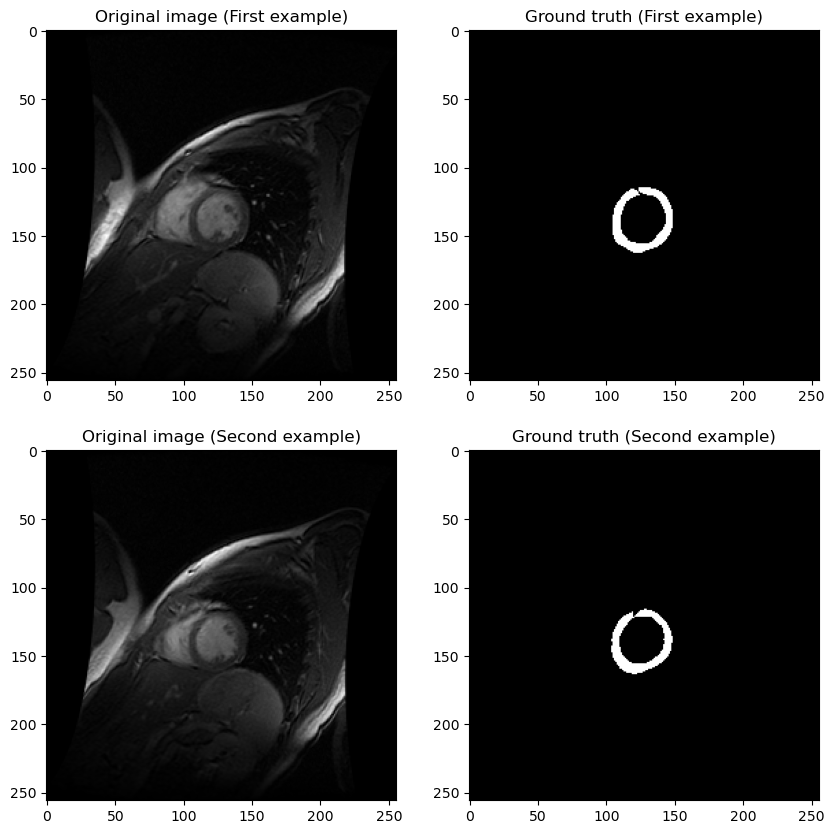

In [12]:
# Plotting the results
fig, axes = plt.subplots(2,2, figsize=(10, 10))
ax        = axes.ravel()

ax[0].imshow(Img_cardiac_ex1, cmap='gray')
ax[0].set_title('Original image (First example)')
ax[1].imshow(Seg_cardiac_ex1, cmap='gray')
ax[1].set_title('Ground truth (First example)')
ax[2].imshow(Img_cardiac_ex2, cmap='gray')
ax[2].set_title('Original image (Second example)')
ax[3].imshow(Seg_cardiac_ex2, cmap='gray')
ax[3].set_title('Ground truth (Second example)');

## 1 Implement a full pipeline to segment TWO EXAMPLES from a single use case. 

Your code must run over the two cases in a loop. We need to be able to run the code without any adjustment to local path to access the input data. <br>

### INITIALIZATION OF THE IMAGES

This following code cell is performing the following tasks:

1. Cropping Images: The code first defines the size of the crop (`crop_size`) and the center coordinates (`center_x` and `center_y`). It then crops two images (`Img_cardiac_ex1` and `Img_cardiac_ex2`) around the defined center and with the defined size. The cropped images are stored in `ex_1` and `ex_2`.

2. Creating an Array of Examples: The cropped images are then put into an array (`examples`).

This code is cropping two images to remove black borders and focus on the area of interest, storing the cropped images in an array, and then visualizing the original and cropped images.

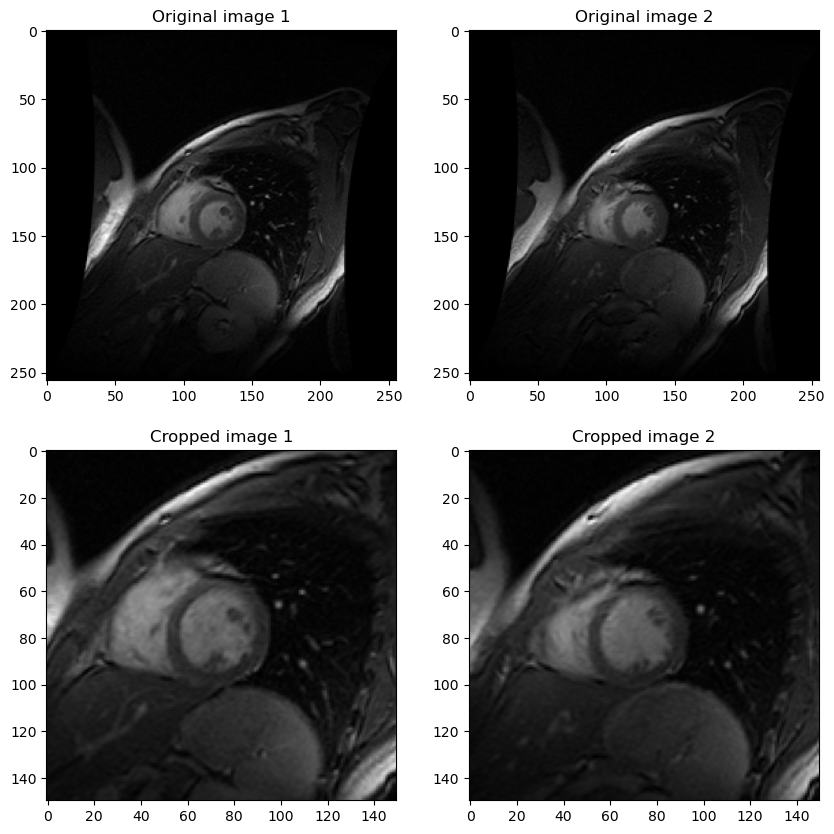

In [13]:
# Cropping the images to remove the black borders
crop_size = 150
center_x = 256 /2 + 7
center_y = 256 /2 

ex_1 = Img_cardiac_ex1[int(center_x - crop_size/2) : int(center_x + crop_size/2), int(center_y - crop_size/2) : int(center_y + crop_size/2)]
ex_2 = Img_cardiac_ex2[int(center_x - crop_size/2) : int(center_x + crop_size/2), int(center_y - crop_size/2) : int(center_y + crop_size/2)]

# Array of the two examples
examples = np.array([ex_1, ex_2])

# Vizualizing the two original images (examples) and the cropped images in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax = axes.ravel()
ax[0].imshow(data[:, :,Ex_index_select_1, t_frame], cmap='gray')
ax[0].set_title('Original image 1')
ax[1].imshow(data[:, :,Ex_index_select_2, t_frame], cmap='gray')
ax[1].set_title('Original image 2')

ax[2].imshow(ex_1, cmap='gray')
ax[2].set_title('Cropped image 1')
ax[3].imshow(ex_2, cmap='gray')
ax[3].set_title('Cropped image 2')
plt.show()

### DEFINITION OF FUNCTIONS FOR PRE-PROCESSING

The following code cell contains three functions related to image processing:

1. `quantize_image(image, n_bins)`: This function takes an image and the number of bins as input. It quantizes the image by dividing the pixel values into `n_bins` intervals. It creates a new image called `quantized_image` with the same shape as the input image, and assigns each pixel to its corresponding bin based on its intensity value. The function then returns the quantized image.

2. `store_evolution_in(lst)`: This function returns a callback function that can be used to store the evolution of level sets in a given list. The input parameter `lst` is the list where the level sets will be stored. The returned callback function, `_store(x)`, takes a level set `x` as input and appends a copy of it to the provided list `lst`. This function is useful for tracking the evolution of level sets during image segmentation or other similar tasks.

3. `apply_vignette_grayscale(image, strength=1.5)`: This function takes an image and a strength value as input. It creates a vignette mask using a Gaussian kernel with the specified strength. The mask is then applied to the image, resulting in a vignette effect where the image fades out towards the edges. The function returns the image with the applied vignette effect.

In [14]:
# Function to quantize the images
def quantize_image(image, n_bins):
    
    interval = 256 / n_bins
    quantized_image = np.zeros_like(image)

    for i in range(n_bins):
        quantized_image[(image >= i * interval) & (image < (i + 1) * interval)] = i

    return quantized_image

def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

def apply_vignette_grayscale(image, strength=1.5):
    rows, cols = image.shape

    # Create a vignette mask
    X_resultant_kernel = cv2.getGaussianKernel(cols, cols / strength)
    Y_resultant_kernel = cv2.getGaussianKernel(rows, rows / strength)
    resultant_kernel = Y_resultant_kernel * X_resultant_kernel.T
    mask = 255 * resultant_kernel / np.linalg.norm(resultant_kernel)
    
    # Apply the mask to the grayscale image
    vignette = image * mask

    return vignette

Applying a vignette effect to an image can serve several purposes, especially in the field of image processing and computer vision. 

**Preprocessing Step**: By darkening the edges of an image and keeping the center bright, a vignette can help to focus the attention on the central part of the image. This is useful as the important information is located in the center of the image.

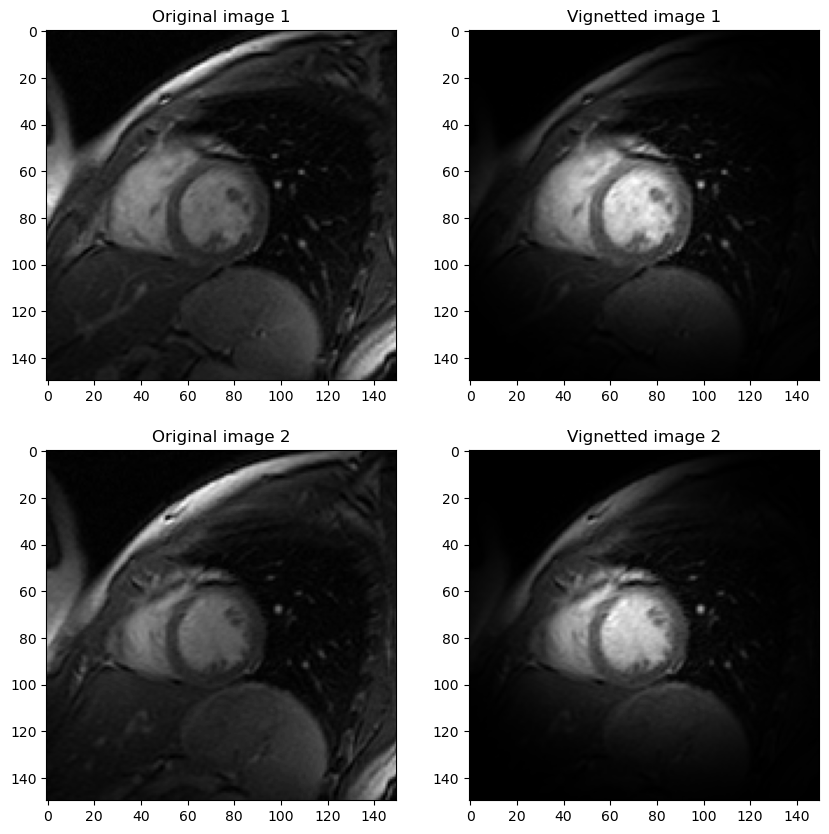

In [15]:
vignetted_image1 = apply_vignette_grayscale(ex_1, strength=5)
vignetted_image2 = apply_vignette_grayscale(ex_2, strength=5)

# Plot the original image and the vignette for ex_1
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax = axes.ravel()
ax[0].imshow(ex_1, cmap='gray')
ax[0].set_title('Original image 1')
ax[1].imshow(vignetted_image1, cmap='gray')
ax[1].set_title('Vignetted image 1')
ax[2].imshow(ex_2, cmap='gray')
ax[2].set_title('Original image 2')
ax[3].imshow(vignetted_image2, cmap='gray')
ax[3].set_title('Vignetted image 2')
plt.show()


### SEGMENTATION OF THE IMAGE - INTERNAL MASK

This code cell is performing the following tasks:

1. **Initialization**: It initializes several arrays to store pre-processed images, segmented images, segmented labels, histograms, and bin histograms. It also sets up parameters for the segmentation process and initializes arrays to store the level sets (`ls`) and binary masks.

2. **Pre-processing**: For each example image, it applies a vignette effect, thresholds the image to binary form based on a specific value (1048), and performs a morphological opening operation (using a disk-shaped structuring element of radius 1) to remove small objects or noise.

3. **Segmentation**: It then performs a morphological geodesic active contour segmentation on the pre-processed image. This is an iterative process where an initial contour (a disk-shaped level set) evolves under the influence of forces derived from the image data and a balloon force. The evolution of the contour is stored in the `evolution` list, which is then appended to `all_evolutions`.

The segmentation parameters are:
   - `Niter_snake`: The number of iterations for the active contour algorithm.
   - `Smooth_cont_iter`: The number of iterations for the smoothing process.
   - `Balloon_weight`: The inflation force that makes the contour expand or shrink.
   - `Thresh_cont_val`: The threshold value for the contour evolution.
   - `R0`, `r0`, `c0`: Parameters to initialize the contour (a disk with radius `R0` at the position `(r0, c0)`).

Overall, this code is performing pre-processing and segmentation on two example images and storing the results and the evolution of the segmentation process.

In [16]:
# INTERNAL SEGEMTNATION OF THE IMAGE -------------------------------------------------------------
# Inizializing the arrays for the results
pre_processed_images = np.zeros((4, crop_size, crop_size))
segmented_images = np.zeros((4, crop_size, crop_size))
segmented_labels = np.zeros((4, crop_size, crop_size))

histograms = np.zeros((4, 256))
bins_hist = np.zeros((4, 257))

# Parameters of segmentation
Niter_snake = 25
Smooth_cont_iter = 1
Balloon_weight = 1
Thresh_cont_val = 0.5
R0 = 2
r0, c0 = 75, 75

# Declare an array to store all the evolutions
all_evolutions = []

# Initialize ls and binary_mask arrays
num_examples, height, width = examples.shape
ls = np.zeros((num_examples*2, height, width))
binary_mask = np.zeros_like(ls)

# Loop over two examples
for i in range(2):
    
    # PRE-PROCESSING STAGE -------------------------------------------------------------
    # Applying a vignette 
    pre_processed_images[i] = apply_vignette_grayscale(examples[i], strength=5)

    # Thresholding the image
    pre_processed_images[i] = pre_processed_images[i] > 1048

    # Closing the image
    pre_processed_images[i] = skimage.morphology.opening(pre_processed_images[i], disk(1))  

    # SEGMENTATION STAGE -------------------------------------------------------------
    
    evolution = []
    callback = store_evolution_in(evolution)

    # Initialise contour 
    init_ls = skimage.segmentation.disk_level_set(pre_processed_images[i].shape, center=[r0, c0], radius = R0)

    # Run geodesic active contour
    ls[i] = skimage.segmentation.morphological_geodesic_active_contour(pre_processed_images[i], Niter_snake, init_ls,
            smoothing=Smooth_cont_iter, balloon=Balloon_weight, threshold=Thresh_cont_val, iter_callback=callback)
    
    # Use all_evolutions
    all_evolutions.append(evolution)

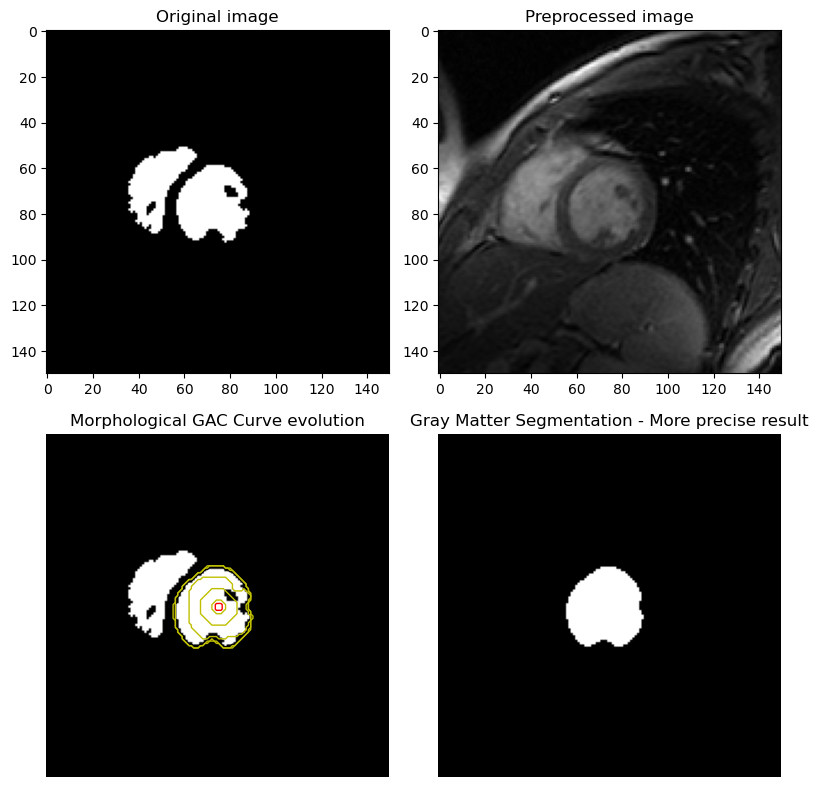

In [17]:
# Plotting the first example, its histogram and the thresholded image
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(pre_processed_images[0], cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(ex_1, cmap='gray')
ax[1].set_title('Preprocessed image')

ax[2].imshow(pre_processed_images[0, :, :], cmap='gray')
ax[2].contour(ls[0], [0.5], cmap="gray")
ax[2].set_axis_off()

contour_ = ax[2].contour(all_evolutions[0][0], [0.5], linewidths=1, colors='r')
contour_.collections[0].set_label("Contours")
title = f'Morphological GAC Curve evolution'
ax[2].set_title(title, fontsize=12)

for i in range(1, Niter_snake-1, 5):
    contour_ = ax[2].contour(all_evolutions[0][i], [0.01], linewidths=1, colors='y')

ax[3].imshow(ls[0], cmap=plt.cm.gray)
ax[3].set_title('Gray Matter Segmentation - More precise result')
ax[3].axis('off')

fig.tight_layout()
plt.show()

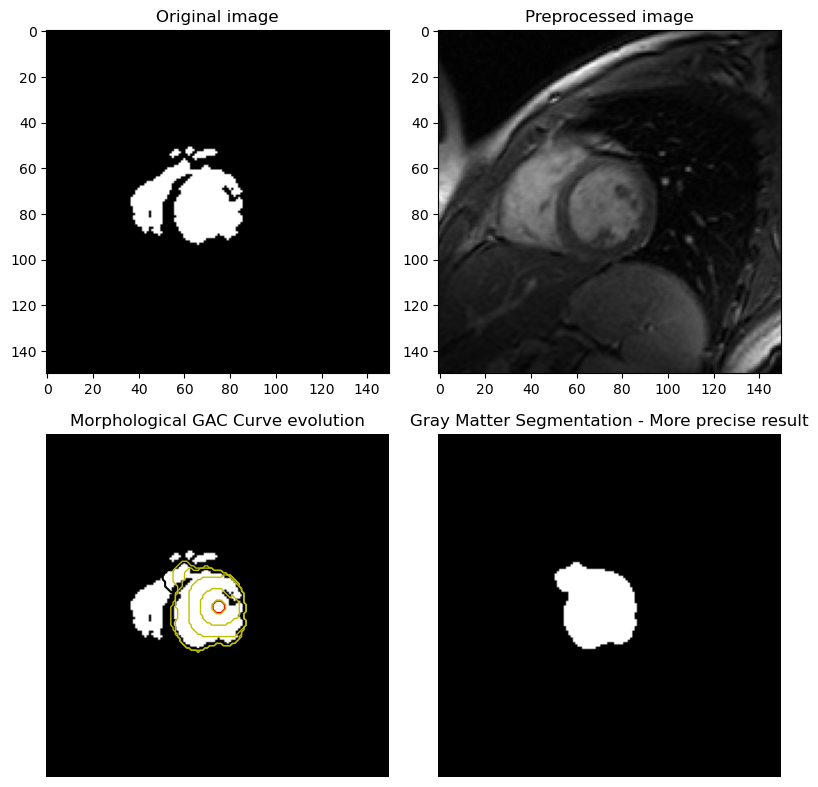

In [18]:
# Plotting the second example, its histogram and the thresholded image
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(pre_processed_images[1], cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(ex_1, cmap='gray')
ax[1].set_title('Preprocessed image')

ax[2].imshow(pre_processed_images[1, :, :], cmap='gray')
ax[2].contour(ls[1], [0.5], cmap="gray")
ax[2].set_axis_off()

contour_ = ax[2].contour(all_evolutions[1][1], [0.5], linewidths=1, colors='r')
contour_.collections[0].set_label("Contours")
title = f'Morphological GAC Curve evolution'
ax[2].set_title(title, fontsize=12)

for i in range(1, Niter_snake-1, 5):
    contour_ = ax[2].contour(all_evolutions[1][i], [0.01], linewidths=1, colors='y')

ax[3].imshow(ls[1], cmap=plt.cm.gray)
ax[3].set_title('Gray Matter Segmentation - More precise result')
ax[3].axis('off')

fig.tight_layout()
plt.show()

### SEGMENTATION OF THE IMAGE - EXTERNAL MASK

The code in this cell is quite similar to the previous one, but there are a few key differences:

1. **Segmentation Parameters**: The parameters for the segmentation process are different. In this cell, `Niter_snake` is 30 (compared to 25 in the previous cell), `Balloon_weight` is -1 (compared to 1 in the previous cell), and `R0` is 25 (compared to 2 in the previous cell). These changes will affect the behavior of the morphological geodesic active contour segmentation.

2. **Pre-processing**: The strength of the vignette effect applied in the pre-processing stage is 1 in this cell, compared to 5 in the previous cell. This will result in a less pronounced vignette effect. The threshold value for the image is also different (600 in this cell compared to 1048 in the previous cell).

3. **Image Indexing**: In the segmentation stage, the index used for the `pre_processed_images` and `ls` arrays is `i+2` in this cell, compared to `i` in the previous cell. This suggests that the results of this cell's operations are being stored in different positions of these arrays compared to the previous cell.

4. **Morphological Operation**: The previous cell included a morphological opening operation in the pre-processing stage, which is not present in this cell.

While the general structure of the code is similar, these differences will result in different pre-processing and segmentation results.

In [19]:
# EXTERNAL SEGEMTNATION OF THE IMAGE -------------------------------------------------------------
# Parameters of segmentation
Niter_snake = 30
Smooth_cont_iter = 1
Balloon_weight = -1
Thresh_cont_val = 0.5
R0 = 25
r0, c0 = 75, 72

# Declare an array to store all the evolutions
all_evolutions = []

# Initialize ls and binary_mask arrays
num_examples, height, width = examples.shape
binary_mask = np.zeros_like(ls)

# Loop over two examples
for i in range(2):
    
    # PRE-PROCESSING STAGE -------------------------------------------------------------
    # Applying a vignette 
    pre_processed_images[i+2] = apply_vignette_grayscale(examples[i], strength=1)

    # Thresholding the image
    pre_processed_images[i+2] = pre_processed_images[i+2] > 600

    # SEGMENTATION STAGE -------------------------------------------------------------

    evolution = []
    callback = store_evolution_in(evolution)

    # Initialise contour 
    init_ls = skimage.segmentation.disk_level_set(pre_processed_images[i+2].shape, center=[r0, c0], radius = R0)

    # Run geodesic active contour
    ls[i+2] = skimage.segmentation.morphological_geodesic_active_contour(pre_processed_images[i+2], Niter_snake, init_ls,
            smoothing=Smooth_cont_iter, balloon=Balloon_weight, threshold=Thresh_cont_val, iter_callback=callback)
    
    # Use all_evolutions
    all_evolutions.append(evolution)

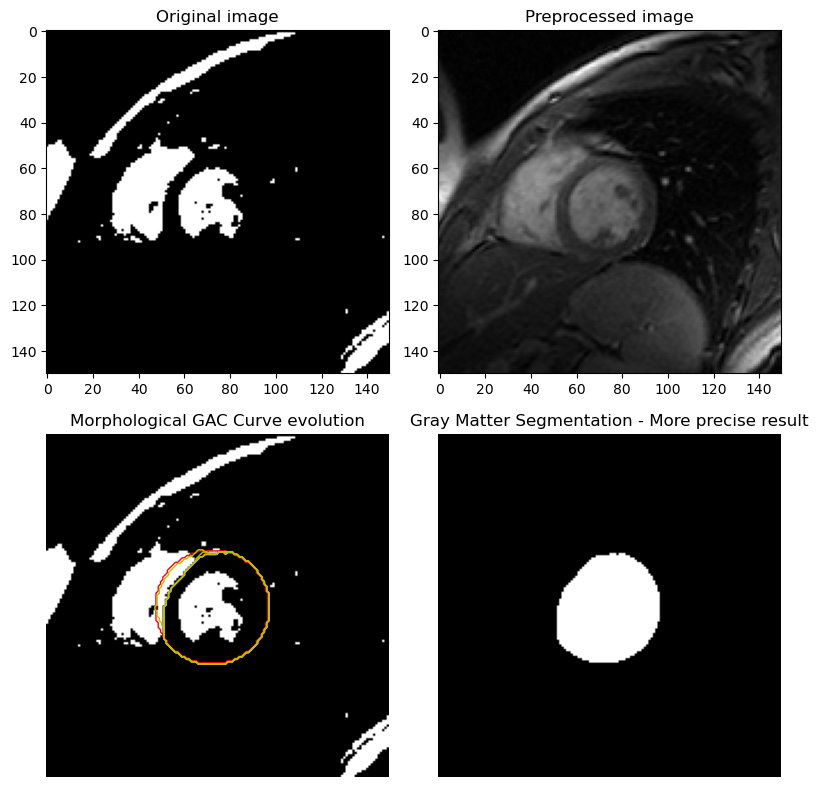

In [20]:
# Plotting the first example, its histogram and the thresholded image
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(pre_processed_images[2], cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(ex_1, cmap='gray')
ax[1].set_title('Preprocessed image')

ax[2].imshow(pre_processed_images[2, :, :], cmap='gray')
ax[2].contour(ls[2], [0.5], cmap="gray")
ax[2].set_axis_off()

contour_ = ax[2].contour(all_evolutions[0][0], [0.5], linewidths=1, colors='r')
contour_.collections[0].set_label("Contours")
title = f'Morphological GAC Curve evolution'
ax[2].set_title(title, fontsize=12)

for i in range(1, Niter_snake-1, 5):
    contour_ = ax[2].contour(all_evolutions[0][i], [0.01], linewidths=1, colors='y')

ax[3].imshow(ls[2], cmap=plt.cm.gray)
ax[3].set_title('Gray Matter Segmentation - More precise result')
ax[3].axis('off')

fig.tight_layout()
plt.show()

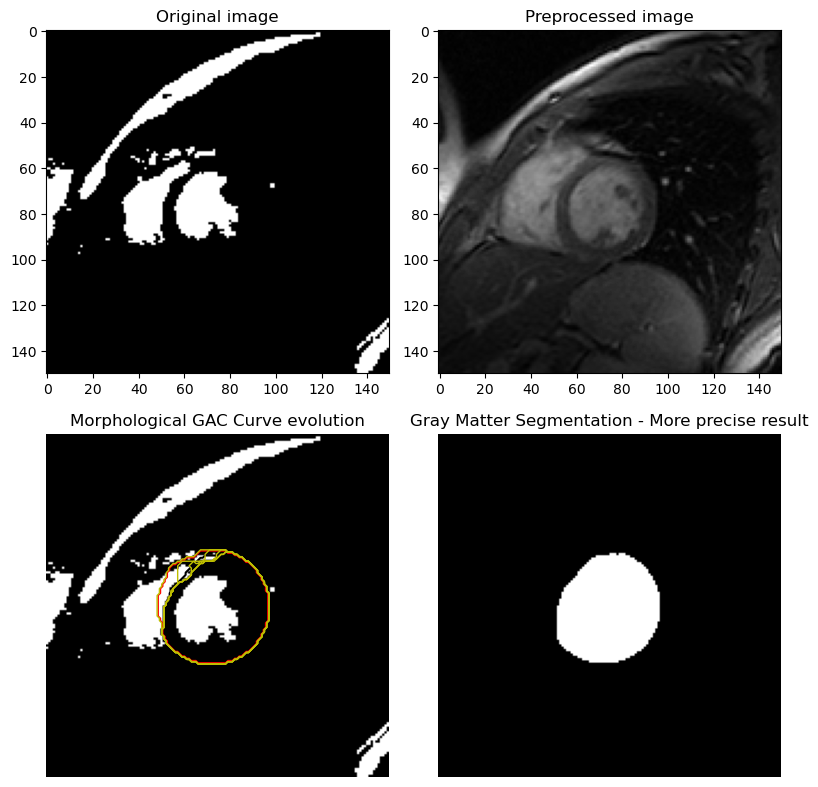

In [21]:
# Plotting the first example, its histogram and the thresholded image
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(pre_processed_images[3], cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(ex_1, cmap='gray')
ax[1].set_title('Preprocessed image')

ax[2].imshow(pre_processed_images[3, :, :], cmap='gray')
ax[2].contour(ls[2], [0.5], cmap="gray")
ax[2].set_axis_off()

contour_ = ax[2].contour(all_evolutions[1][1], [0.5], linewidths=1, colors='r')
contour_.collections[0].set_label("Contours")
title = f'Morphological GAC Curve evolution'
ax[2].set_title(title, fontsize=12)

for i in range(1, Niter_snake-1, 5):
    contour_ = ax[2].contour(all_evolutions[1][i], [0.01], linewidths=1, colors='y')

ax[3].imshow(ls[2], cmap=plt.cm.gray)
ax[3].set_title('Gray Matter Segmentation - More precise result')
ax[3].axis('off')

fig.tight_layout()
plt.show()

## COMBINING MASKS

This code cell is combining the results of the internal and external segmentation processes and then visualizing the results.

1. **Initialization**: It initializes an array `final_mask` with the same shape as `ls` to store the final segmentation mask.

2. **Binary Conversion**: It converts the level sets `ls[0]`, `ls[1]`, `ls[2]`, and `ls[3]` to binary form. This is done by checking if the values in these arrays are equal to 0, which results in a boolean array (True where the condition is met and False otherwise).

3. **Combining Masks**: It combines the internal and external segmentation masks (`ls[0]` and `ls[2]`) by subtracting one from the other and taking the absolute value. This operation is equivalent to a logical AND operation between the two binary masks. The result is stored in `final_mask[0]`.

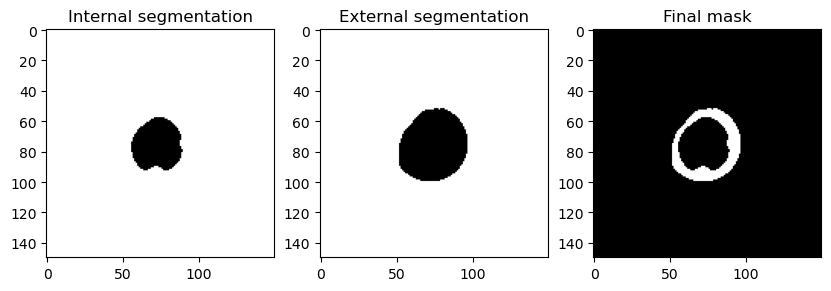

In [22]:
# COMBINING THE INTERNAL AND EXTERNAL SEGMENTATION -------------------------------------------------------------
final_mask = np.zeros_like(ls)

ls[0], ls[1] = ls[0] == 0, ls[1] == 0
ls[2], ls[3] = ls[2] == 0, ls[3] == 0

# Combining the two masks (AND)
final_mask[0] = abs(ls[2] - ls[0])

# Plotting each mask, the final mask and the ground truth
fig, axes = plt.subplots(1, 3, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(ls[0], cmap='gray')
ax[0].set_title('Internal segmentation')

ax[1].imshow(ls[2], cmap='gray')
ax[1].set_title('External segmentation')

ax[2].imshow(final_mask[0], cmap='gray')
ax[2].set_title('Final mask')
plt.show()

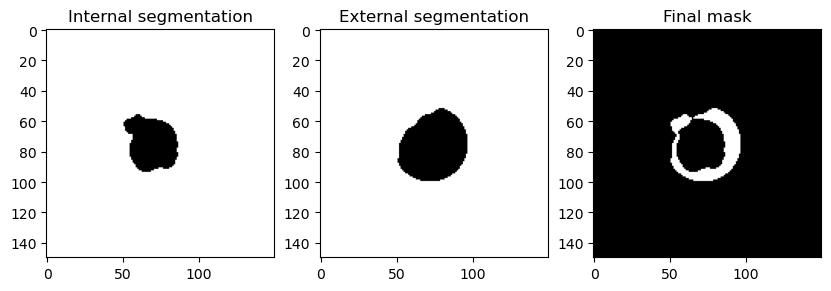

In [23]:
# COMBINING THE INTERNAL AND EXTERNAL SEGMENTATION -------------------------------------------------------------

# Combining the two masks (AND)
final_mask[1] = abs(ls[3] - ls[1])

# Plotting each mask, the final mask and the ground truth
fig, axes = plt.subplots(1, 3, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(ls[1], cmap='gray')
ax[0].set_title('Internal segmentation')

ax[1].imshow(ls[3], cmap='gray')
ax[1].set_title('External segmentation')

ax[2].imshow(abs(ls[3] - ls[1]), cmap='gray')
ax[2].set_title('Final mask')
plt.show()

* Implement and compute a quality metric (eg Dice, overlap, relative area differences, errors between max diameters (something used to measure tumors), distances between contours) that compares your final segmentation with the ground-truth.

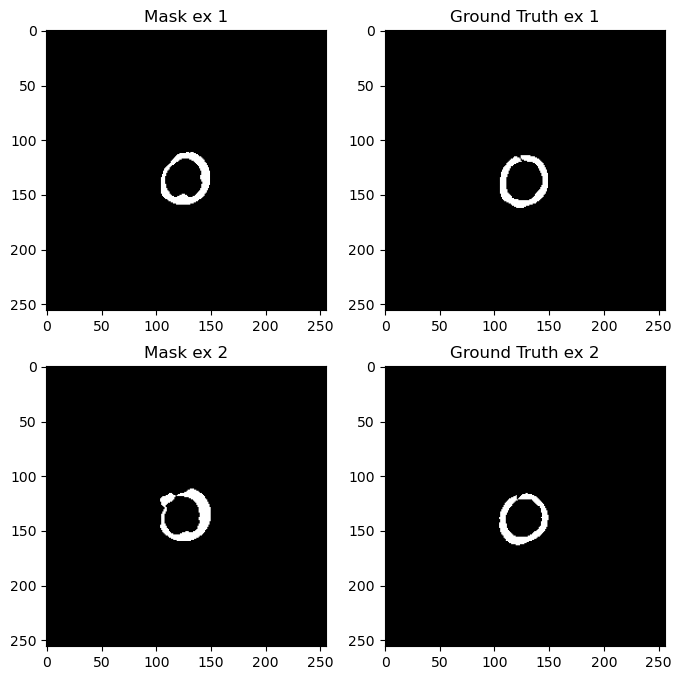

In [24]:
# Setting back the masks dimentions to the original size
# Mask 1 
mask_ex1 = np.zeros_like(data[:, :,Ex_index_select_1, t_frame])
final_mask[0] = (final_mask[0] != 0)
mask_ex1[int(center_x - crop_size/2) : int(center_x + crop_size/2), 
     int(center_y - crop_size/2) : int(center_y + crop_size/2)] = final_mask[0]

# Mask 2
mask_ex2 = np.zeros_like(data[:, :,Ex_index_select_2, t_frame])
final_mask[1] = (final_mask[1] != 0)
mask_ex2[int(center_x - crop_size/2) : int(center_x + crop_size/2), 
     int(center_y - crop_size/2) : int(center_y + crop_size/2)] = final_mask[1]

# Plotting the masks and the grounds truths
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(mask_ex1, cmap='gray')
ax[0].set_title('Mask ex 1')
ax[1].imshow(Seg_cardiac_ex1, cmap='gray')
ax[1].set_title('Ground Truth ex 1')

ax[2].imshow(mask_ex2, cmap='gray')
ax[2].set_title('Mask ex 2')
ax[3].imshow(Seg_cardiac_ex2, cmap='gray')
ax[3].set_title('Ground Truth ex 2')
plt.show()

These functions are used to calculate different metrics that measure the similarity between two binary masks, typically a predicted mask and a ground truth mask. These metrics are commonly used in image segmentation tasks.

1. **Intersection over Union (IoU)**: The `calculate_iou` function calculates the Intersection over Union (IoU) metric, also known as the Jaccard index. This metric measures the overlap between two binary masks. It is calculated as the area of intersection divided by the area of union of the two masks.

2. **Relative Absolute Difference (RAD)**: The `calculate_rad` function calculates the Relative Absolute Difference (RAD) between the predicted mask and the ground truth mask. This metric measures the absolute difference between the sum of the predicted mask and the sum of the ground truth mask, divided by the sum of the ground truth mask.

3. **Hausdorff Distance**: The `hausdorff_distance` function calculates the Hausdorff distance between two binary masks. The Hausdorff distance is a measure of the greatest of all the distances from a point in one set to the closest point in the other set. It uses the `directed_hausdorff` function from the `scipy.spatial.distance` module to calculate the directed Hausdorff distance from `u` to `v` and from `v` to `u`, and returns the maximum of these two distances.

After defining the functions, the code calculates the intersection and dice coefficient for two examples, `intersection_1` and `dice_coefficient_1` for example 1, and `intersection_2` and `dice_coefficient_2` for example 2. The dice coefficient is a similarity metric that measures the overlap between two binary masks. It is calculated by taking twice the sum of the intersection and dividing it by the sum of the two masks.

In [25]:
def calculate_iou(predicted_mask, ground_truth_mask):
    intersection = np.logical_and(predicted_mask, ground_truth_mask)
    union = np.logical_or(predicted_mask, ground_truth_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_rad(predicted_mask, ground_truth_mask):
    rad = np.abs(np.sum(predicted_mask) - np.sum(ground_truth_mask)) / np.sum(ground_truth_mask)
    return rad

from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance(u, v):
    return max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

In [26]:
intersection_1 = np.logical_and(mask_ex1, Seg_cardiac_ex1)
dice_coefficient_1 = 2. * intersection_1.sum() / (mask_ex1.sum() + Seg_cardiac_ex1.sum())

intersection_2 = np.logical_and(mask_ex2, Seg_cardiac_ex2)
dice_coefficient_2 = 2. * intersection_2.sum() / (mask_ex2.sum() + Seg_cardiac_ex2.sum())

iou_1 = calculate_iou(mask_ex1, Seg_cardiac_ex1)
rad_1 = calculate_rad(mask_ex1, Seg_cardiac_ex1)

iou_2 = calculate_iou(mask_ex2, Seg_cardiac_ex2)
rad_2 = calculate_rad(mask_ex2, Seg_cardiac_ex2)

hausdorff_dist_1 = hausdorff_distance(mask_ex1, Seg_cardiac_ex1)
hausdorff_dist_2 = hausdorff_distance(mask_ex2, Seg_cardiac_ex2)

Text(0.5, 1.0, 'Intersection ex 2')

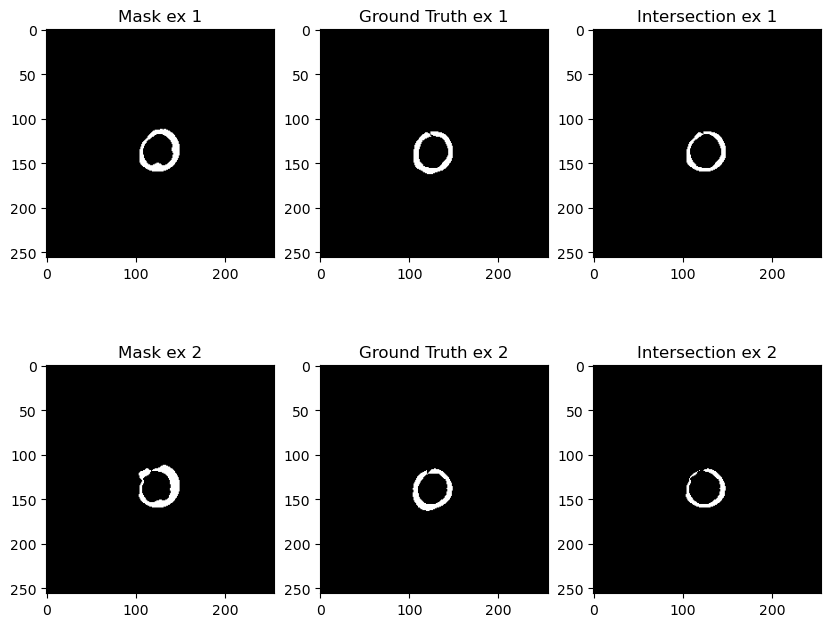

In [27]:
# Plotting the mask obtained with the segmentation, the ground truth and the intersection in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
ax = axes.ravel()

ax[0].imshow(mask_ex1, cmap='gray')
ax[0].set_title('Mask ex 1')
ax[1].imshow(Seg_cardiac_ex1, cmap='gray')
ax[1].set_title('Ground Truth ex 1')
ax[2].imshow(intersection_1, cmap='gray')
ax[2].set_title('Intersection ex 1')

ax[3].imshow(mask_ex2, cmap='gray')
ax[3].set_title('Mask ex 2')
ax[4].imshow(Seg_cardiac_ex2, cmap='gray')
ax[4].set_title('Ground Truth ex 2')
ax[5].imshow(intersection_2, cmap='gray')
ax[5].set_title('Intersection ex 2')

Text(0.5, 1.0, 'Union ex 2')

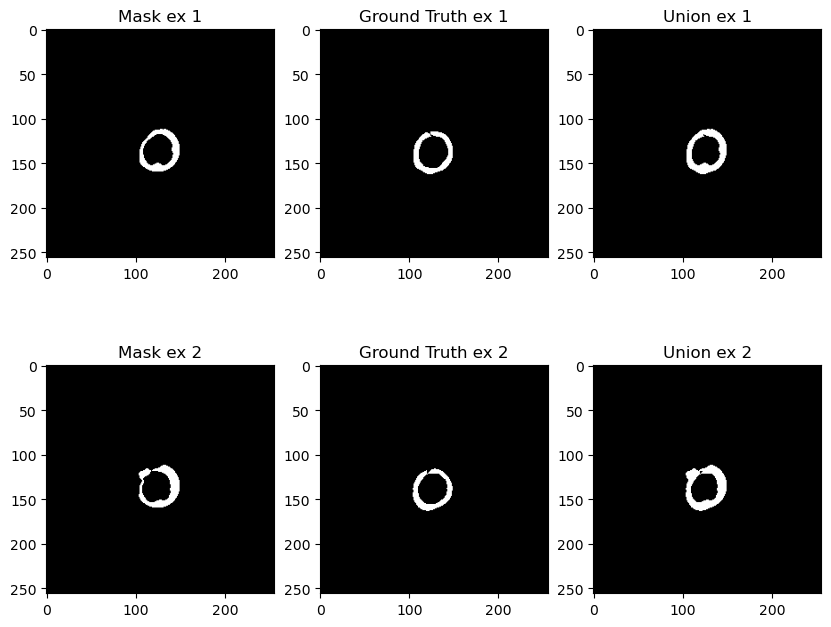

In [28]:
# Plotting the mask obtained with the segmentation, the ground truth and the union in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
ax = axes.ravel()

ax[0].imshow(mask_ex1, cmap='gray')
ax[0].set_title('Mask ex 1')
ax[1].imshow(Seg_cardiac_ex1, cmap='gray')
ax[1].set_title('Ground Truth ex 1')
ax[2].imshow(np.logical_or(mask_ex1, Seg_cardiac_ex1), cmap='gray')
ax[2].set_title('Union ex 1')

ax[3].imshow(mask_ex2, cmap='gray')
ax[3].set_title('Mask ex 2')
ax[4].imshow(Seg_cardiac_ex2, cmap='gray')
ax[4].set_title('Ground Truth ex 2')
ax[5].imshow(np.logical_or(mask_ex2, Seg_cardiac_ex2), cmap='gray')
ax[5].set_title('Union ex 2')

In [29]:
print("Example 1 -------------------")
print("Dice Coefficient:", dice_coefficient_1)
print("Intersection over Union (IoU):", iou_1)
print("Relative Area Difference (RAD):", rad_1)
print("Hausdorff Distance:", hausdorff_dist_1)
print('\n')

print("Example 2 -------------------")
print("Dice Coefficient:", dice_coefficient_2)
print("Intersection over Union (IoU):", iou_2)
print("Relative Area Difference (RAD):", rad_2)
print("Hausdorff Distance:", hausdorff_dist_2)

Example 1 -------------------
Dice Coefficient: 0.772020725388601
Intersection over Union (IoU): 0.6286919831223629
Relative Area Difference (RAD): 0.0559254327563249
Hausdorff Distance: 3.4641016151377544


Example 2 -------------------
Dice Coefficient: 0.6375711574952562
Intersection over Union (IoU): 0.467966573816156
Relative Area Difference (RAD): 0.19583333333333333
Hausdorff Distance: 3.872983346207417


1. **Intersection over Union (IoU)**: For the first example, the IoU is around 0.63, which indicates that about 63% of the union of the predicted and ground truth masks is an intersection. This suggests a good overlap between the predicted and actual areas. For the second example, the IoU is lower at around 0.47, indicating a moderate overlap.

2. **Dice Coefficient**: The Dice Coefficient for the first example is around 0.77, which is a good score indicating a high overlap between the predicted and actual areas. For the second example, the Dice Coefficient is lower at around 0.64, indicating a moderate overlap.

3. **Relative Area Difference (RAD)**: The RAD value for the first example is quite low (around 0.056), which indicates that the total areas of the predicted and actual masks are relatively similar. For the second example, the RAD is higher at around 0.196, indicating a larger difference between the areas of the predicted and actual masks.

4. **Hausdorff Distance**: The Hausdorff Distance for the first example is around 3.46, and for the second example it's higher at around 3.87. These metrics measure the greatest distance from a point in the predicted mask to the closest point in the ground truth mask. The values suggest that the predicted and actual masks are relatively close to each other, but the second example has a slightly larger maximum distance.

Overall, these metrics suggest that the segmentation model has a good performance for the first example and a moderate performance for the second example.

# PROVING THE ALGORITHM IN MORE USE-CASES

* Extra point if you provide results on more use-cases or more than 2 examples per use case. <br>

In [30]:
t_frame = 5
Ex_index_select_1, Ex_index_select_2 = 2, 3
Img_cardiac_ex1, Img_cardiac_ex2 = data[:,:,Ex_index_select_1, 1], data[:,:,Ex_index_select_2, 2] 
Cont_cardiac_ex1, Cont_cardiac_ex2  = seg[Ex_index_select_1,1][:], seg[Ex_index_select_2,1][:]

# Remove [0 0] point in provided contour
Cont_cardiac_ex1 = Cont_cardiac_ex1[~np.all(Cont_cardiac_ex1 == 0, axis=1)]
Cont_cardiac_ex2 = Cont_cardiac_ex2[~np.all(Cont_cardiac_ex2 == 0, axis=1)]

# Obtaining the grounds truths
Seg_cardiac_ex1   = np.zeros_like(Img_cardiac_ex1, dtype='bool')
rr1, cc1 = polygon(Cont_cardiac_ex1[:, 1], Cont_cardiac_ex1[:, 0], Img_cardiac_ex1.shape)
Seg_cardiac_ex1[rr1, cc1] = 1

Seg_cardiac_ex2   = np.zeros_like(Img_cardiac_ex2, dtype='bool')
rr2, cc2 = polygon(Cont_cardiac_ex2[:, 1], Cont_cardiac_ex2[:, 0], Img_cardiac_ex2.shape)
Seg_cardiac_ex2[rr2, cc2] = 1

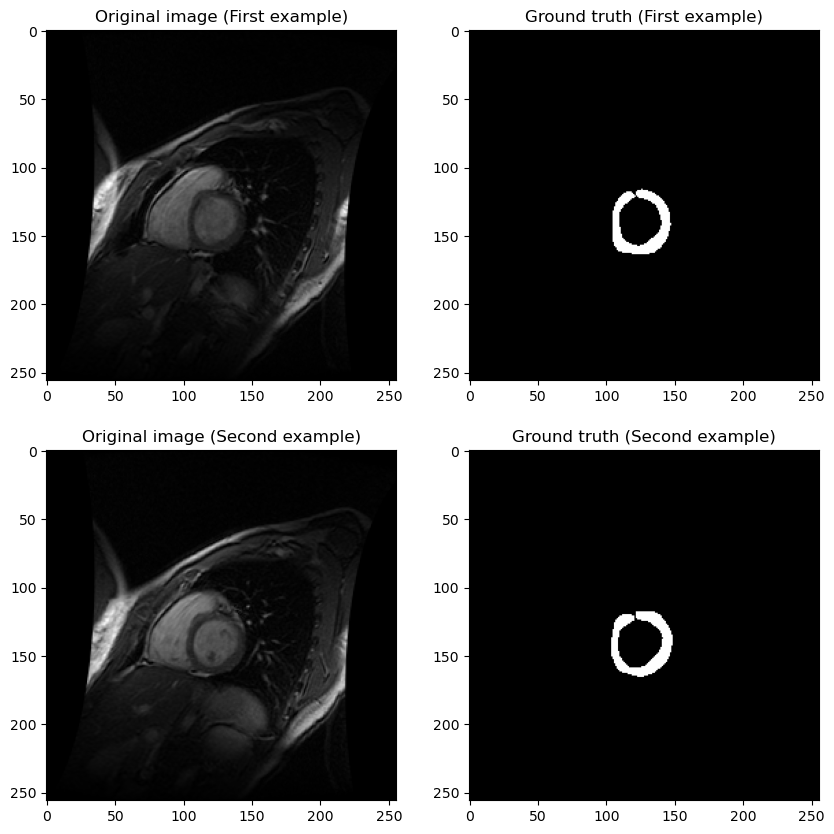

In [31]:
# Plotting the results
fig, axes = plt.subplots(2,2, figsize=(10, 10))
ax        = axes.ravel()

ax[0].imshow(Img_cardiac_ex1, cmap='gray')
ax[0].set_title('Original image (First example)')
ax[1].imshow(Seg_cardiac_ex1, cmap='gray')
ax[1].set_title('Ground truth (First example)')
ax[2].imshow(Img_cardiac_ex2, cmap='gray')
ax[2].set_title('Original image (Second example)')
ax[3].imshow(Seg_cardiac_ex2, cmap='gray')
ax[3].set_title('Ground truth (Second example)');

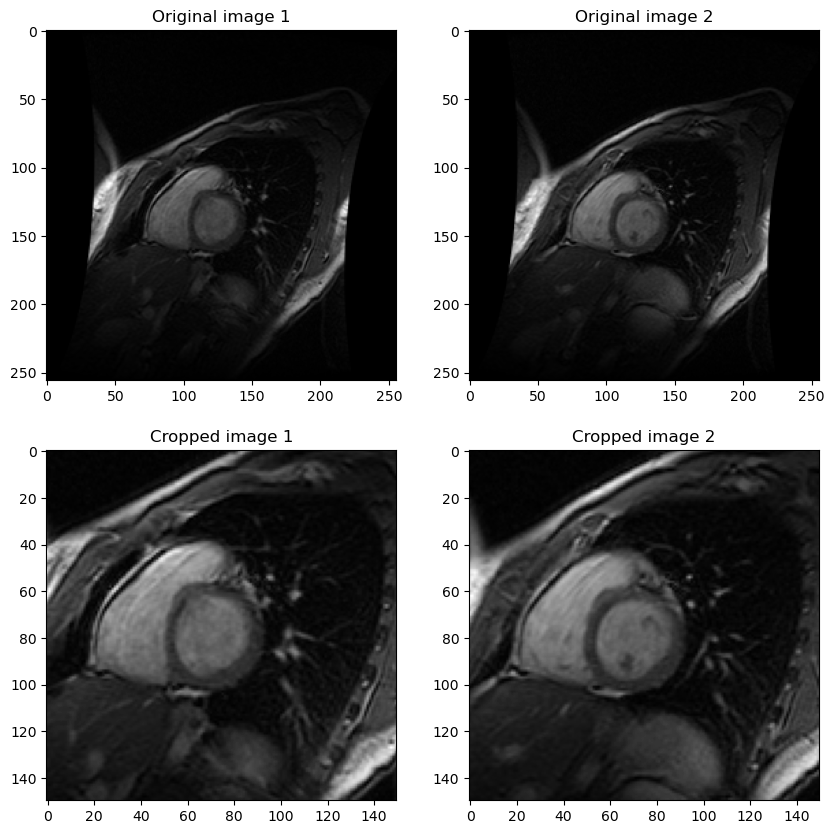

In [32]:
# Cropping the images to remove the black borders
crop_size = 150
center_x = 256 /2 + 7
center_y = 256 /2 

ex_1 = Img_cardiac_ex1[int(center_x - crop_size/2) : int(center_x + crop_size/2), int(center_y - crop_size/2) : int(center_y + crop_size/2)]
ex_2 = Img_cardiac_ex2[int(center_x - crop_size/2) : int(center_x + crop_size/2), int(center_y - crop_size/2) : int(center_y + crop_size/2)]

# Array of the two examples
examples = np.array([ex_1, ex_2])

# Vizualizing the two original images (examples) and the cropped images in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax = axes.ravel()
ax[0].imshow(Img_cardiac_ex1, cmap='gray')
ax[0].set_title('Original image 1')
ax[1].imshow(Img_cardiac_ex2, cmap='gray')
ax[1].set_title('Original image 2')

ax[2].imshow(ex_1, cmap='gray')
ax[2].set_title('Cropped image 1')
ax[3].imshow(ex_2, cmap='gray')
ax[3].set_title('Cropped image 2')
plt.show()

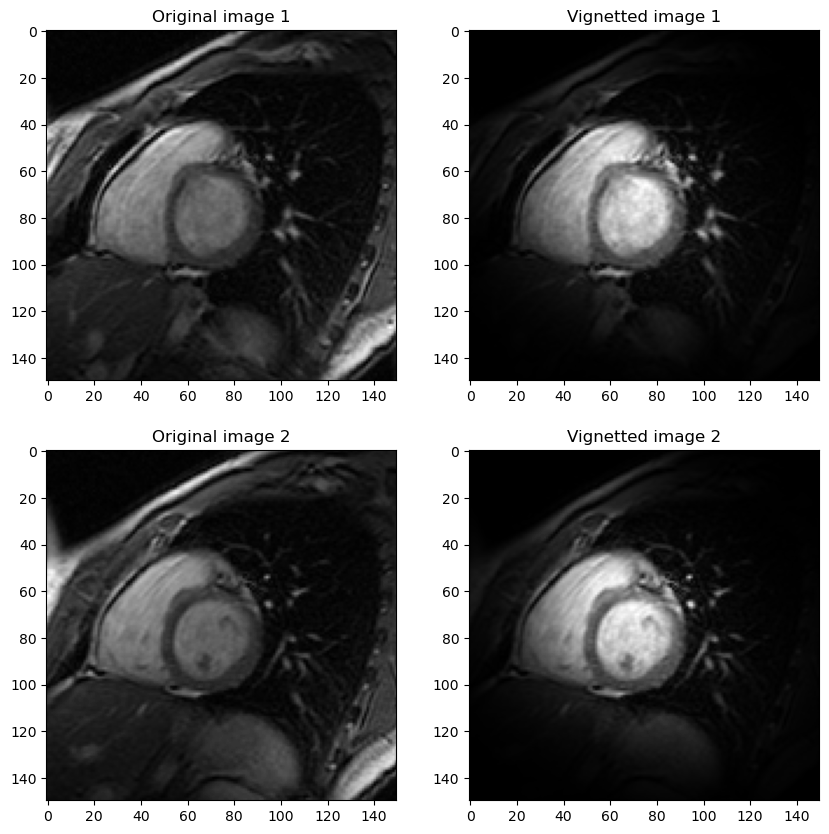

In [33]:
vignetted_image1 = apply_vignette_grayscale(ex_1, strength=5)
vignetted_image2 = apply_vignette_grayscale(ex_2, strength=5)

# Plot the original image and the vignette for ex_1
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax = axes.ravel()
ax[0].imshow(ex_1, cmap='gray')
ax[0].set_title('Original image 1')
ax[1].imshow(vignetted_image1, cmap='gray')
ax[1].set_title('Vignetted image 1')
ax[2].imshow(ex_2, cmap='gray')
ax[2].set_title('Original image 2')
ax[3].imshow(vignetted_image2, cmap='gray')
ax[3].set_title('Vignetted image 2')
plt.show()

In [34]:
# INTERNAL SEGEMTNATION OF THE IMAGE -------------------------------------------------------------
# Inizializing the arrays for the results
pre_processed_images = np.zeros((4, crop_size, crop_size))
segmented_images = np.zeros((4, crop_size, crop_size))
segmented_labels = np.zeros((4, crop_size, crop_size))

histograms = np.zeros((4, 256))
bins_hist = np.zeros((4, 257))

# Parameters of segmentation
Niter_snake = 25
Smooth_cont_iter = 1
Balloon_weight = 1
Thresh_cont_val = 0.5
R0 = 2
r0, c0 = 75, 75

# Declare an array to store all the evolutions
all_evolutions = []

# Initialize ls and binary_mask arrays
num_examples, height, width = examples.shape
ls = np.zeros((num_examples*2, height, width))
binary_mask = np.zeros_like(ls)

# Loop over two examples
for i in range(2):
    
    # PRE-PROCESSING STAGE -------------------------------------------------------------
    # Applying a vignette 
    pre_processed_images[i] = apply_vignette_grayscale(examples[i], strength=5)

    # Thresholding the image
    pre_processed_images[i] = pre_processed_images[i] > 1048

    # Closing the image
    pre_processed_images[i] = skimage.morphology.opening(pre_processed_images[i], disk(1))  

    # SEGMENTATION STAGE -------------------------------------------------------------
    
    evolution = []
    callback = store_evolution_in(evolution)

    # Initialise contour 
    init_ls = skimage.segmentation.disk_level_set(pre_processed_images[i].shape, center=[r0, c0], radius = R0)

    # Run geodesic active contour
    ls[i] = skimage.segmentation.morphological_geodesic_active_contour(pre_processed_images[i], Niter_snake, init_ls,
            smoothing=Smooth_cont_iter, balloon=Balloon_weight, threshold=Thresh_cont_val, iter_callback=callback)
    
    # Use all_evolutions
    all_evolutions.append(evolution)

In [35]:
# EXTERNAL SEGEMTNATION OF THE IMAGE -------------------------------------------------------------
# Parameters of segmentation
Niter_snake = 30
Smooth_cont_iter = 1
Balloon_weight = -1
Thresh_cont_val = 0.5
R0 = 25
r0, c0 = 75, 72

# Declare an array to store all the evolutions
all_evolutions = []

# Initialize ls and binary_mask arrays
num_examples, height, width = examples.shape
binary_mask = np.zeros_like(ls)

# Loop over two examples
for i in range(2):
    
    # PRE-PROCESSING STAGE -------------------------------------------------------------
    # Applying a vignette 
    pre_processed_images[i+2] = apply_vignette_grayscale(examples[i], strength=1)

    # Thresholding the image
    pre_processed_images[i+2] = pre_processed_images[i+2] > 600

    # SEGMENTATION STAGE -------------------------------------------------------------

    evolution = []
    callback = store_evolution_in(evolution)

    # Initialise contour 
    init_ls = skimage.segmentation.disk_level_set(pre_processed_images[i+2].shape, center=[r0, c0], radius = R0)

    # Run geodesic active contour
    ls[i+2] = skimage.segmentation.morphological_geodesic_active_contour(pre_processed_images[i+2], Niter_snake, init_ls,
            smoothing=Smooth_cont_iter, balloon=Balloon_weight, threshold=Thresh_cont_val, iter_callback=callback)
    
    # Use all_evolutions
    all_evolutions.append(evolution)

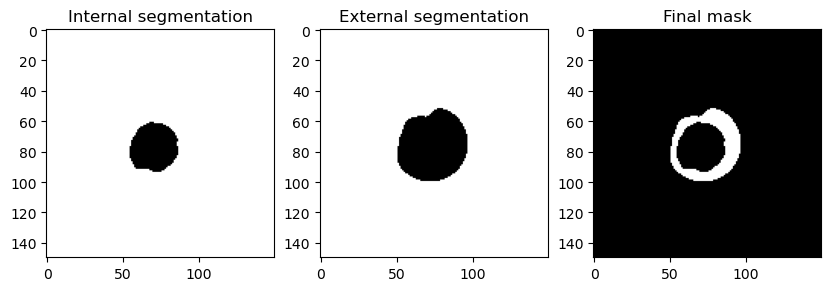

In [36]:
# COMBINING THE INTERNAL AND EXTERNAL SEGMENTATION -------------------------------------------------------------
final_mask = np.zeros_like(ls)

ls[0], ls[1] = ls[0] == 0, ls[1] == 0
ls[2], ls[3] = ls[2] == 0, ls[3] == 0

# Combining the two masks (AND)
final_mask[0] = abs(ls[2] - ls[0])

# Plotting each mask, the final mask and the ground truth
fig, axes = plt.subplots(1, 3, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(ls[0], cmap='gray')
ax[0].set_title('Internal segmentation')

ax[1].imshow(ls[2], cmap='gray')
ax[1].set_title('External segmentation')

ax[2].imshow(final_mask[0], cmap='gray')
ax[2].set_title('Final mask')
plt.show()

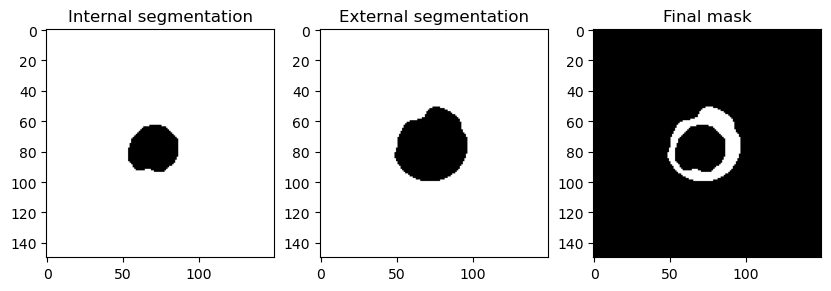

In [37]:
# COMBINING THE INTERNAL AND EXTERNAL SEGMENTATION -------------------------------------------------------------

# Combining the two masks (AND)
final_mask[1] = abs(ls[3] - ls[1])

# Plotting each mask, the final mask and the ground truth
fig, axes = plt.subplots(1, 3, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(ls[1], cmap='gray')
ax[0].set_title('Internal segmentation')

ax[1].imshow(ls[3], cmap='gray')
ax[1].set_title('External segmentation')

ax[2].imshow(abs(ls[3] - ls[1]), cmap='gray')
ax[2].set_title('Final mask')
plt.show()

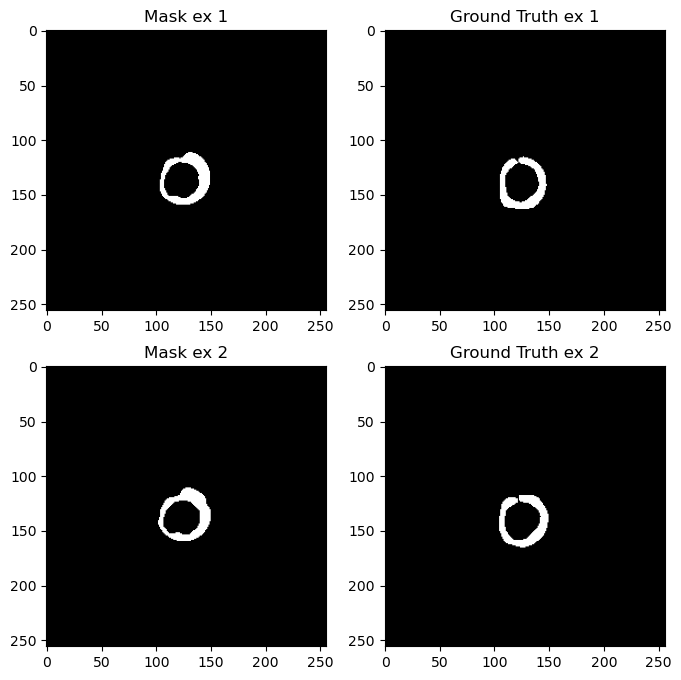

In [38]:
# Setting back the masks dimentions to the original size
# Mask 1 
mask_ex1 = np.zeros_like(data[:, :,Ex_index_select_1, t_frame])
final_mask[0] = (final_mask[0] != 0)
mask_ex1[int(center_x - crop_size/2) : int(center_x + crop_size/2), 
     int(center_y - crop_size/2) : int(center_y + crop_size/2)] = final_mask[0]

# Mask 2
mask_ex2 = np.zeros_like(data[:, :,Ex_index_select_2, t_frame])
final_mask[1] = (final_mask[1] != 0)
mask_ex2[int(center_x - crop_size/2) : int(center_x + crop_size/2), 
     int(center_y - crop_size/2) : int(center_y + crop_size/2)] = final_mask[1]

# Plotting the masks and the grounds truths
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(mask_ex1, cmap='gray')
ax[0].set_title('Mask ex 1')
ax[1].imshow(Seg_cardiac_ex1, cmap='gray')
ax[1].set_title('Ground Truth ex 1')

ax[2].imshow(mask_ex2, cmap='gray')
ax[2].set_title('Mask ex 2')
ax[3].imshow(Seg_cardiac_ex2, cmap='gray')
ax[3].set_title('Ground Truth ex 2')
plt.show()

In [39]:
intersection_1 = np.logical_and(mask_ex1, Seg_cardiac_ex1)
dice_coefficient_1 = 2. * intersection_1.sum() / (mask_ex1.sum() + Seg_cardiac_ex1.sum())

intersection_2 = np.logical_and(mask_ex2, Seg_cardiac_ex2)
dice_coefficient_2 = 2. * intersection_2.sum() / (mask_ex2.sum() + Seg_cardiac_ex2.sum())

iou_1 = calculate_iou(mask_ex1, Seg_cardiac_ex1)
rad_1 = calculate_rad(mask_ex1, Seg_cardiac_ex1)

iou_2 = calculate_iou(mask_ex2, Seg_cardiac_ex2)
rad_2 = calculate_rad(mask_ex2, Seg_cardiac_ex2)

hausdorff_dist_1 = hausdorff_distance(mask_ex1, Seg_cardiac_ex1)
hausdorff_dist_2 = hausdorff_distance(mask_ex2, Seg_cardiac_ex2)

Text(0.5, 1.0, 'Intersection ex 2')

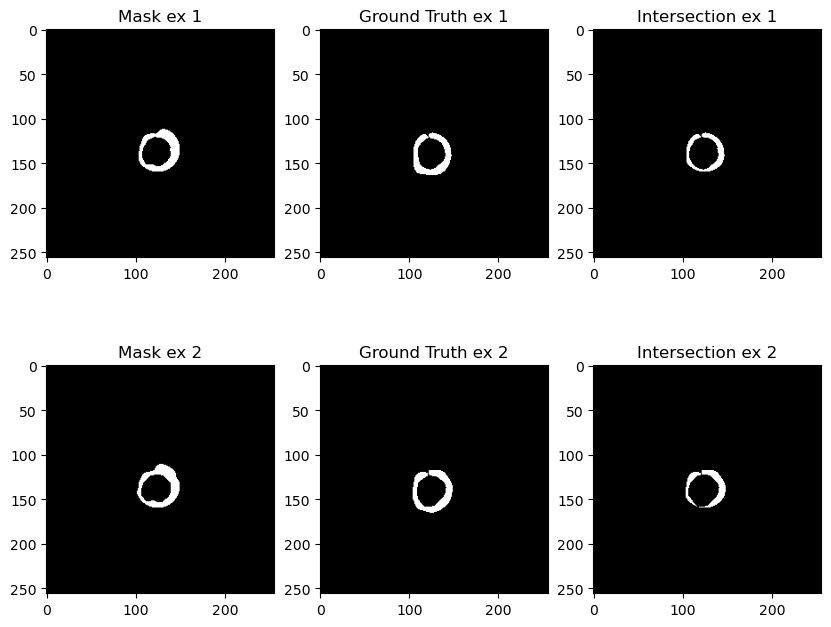

In [40]:
# Plotting the mask obtained with the segmentation, the ground truth and the intersection in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
ax = axes.ravel()

ax[0].imshow(mask_ex1, cmap='gray')
ax[0].set_title('Mask ex 1')
ax[1].imshow(Seg_cardiac_ex1, cmap='gray')
ax[1].set_title('Ground Truth ex 1')
ax[2].imshow(intersection_1, cmap='gray')
ax[2].set_title('Intersection ex 1')

ax[3].imshow(mask_ex2, cmap='gray')
ax[3].set_title('Mask ex 2')
ax[4].imshow(Seg_cardiac_ex2, cmap='gray')
ax[4].set_title('Ground Truth ex 2')
ax[5].imshow(intersection_2, cmap='gray')
ax[5].set_title('Intersection ex 2')

Text(0.5, 1.0, 'Union ex 2')

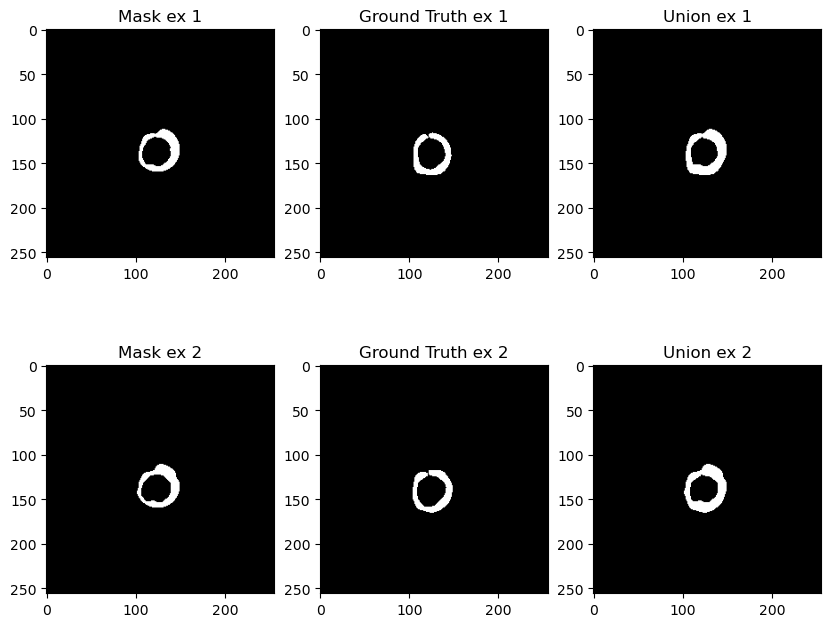

In [41]:
# Plotting the mask obtained with the segmentation, the ground truth and the union in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
ax = axes.ravel()

ax[0].imshow(mask_ex1, cmap='gray')
ax[0].set_title('Mask ex 1')
ax[1].imshow(Seg_cardiac_ex1, cmap='gray')
ax[1].set_title('Ground Truth ex 1')
ax[2].imshow(np.logical_or(mask_ex1, Seg_cardiac_ex1), cmap='gray')
ax[2].set_title('Union ex 1')

ax[3].imshow(mask_ex2, cmap='gray')
ax[3].set_title('Mask ex 2')
ax[4].imshow(Seg_cardiac_ex2, cmap='gray')
ax[4].set_title('Ground Truth ex 2')
ax[5].imshow(np.logical_or(mask_ex2, Seg_cardiac_ex2), cmap='gray')
ax[5].set_title('Union ex 2')

In [42]:
print("Example 1 -------------------")
print("Dice Coefficient:", dice_coefficient_1)
print("Intersection over Union (IoU):", iou_1)
print("Relative Area Difference (RAD):", rad_1)
print("Hausdorff Distance:", hausdorff_dist_1)
print('\n')

print("Example 2 -------------------")
print("Dice Coefficient:", dice_coefficient_2)
print("Intersection over Union (IoU):", iou_2)
print("Relative Area Difference (RAD):", rad_2)
print("Hausdorff Distance:", hausdorff_dist_2)

Example 1 -------------------
Dice Coefficient: 0.6810933940774487
Intersection over Union (IoU): 0.5164075993091537
Relative Area Difference (RAD): 0.07565011820330969
Hausdorff Distance: 3.605551275463989


Example 2 -------------------
Dice Coefficient: 0.6769911504424779
Intersection over Union (IoU): 0.5117056856187291
Relative Area Difference (RAD): 0.05922551252847381
Hausdorff Distance: 3.4641016151377544


1. **Intersection over Union (IoU)**: For both examples, the IoU is around 0.51, which indicates that about 51% of the union of the predicted and ground truth masks is an intersection. This suggests a moderate overlap between the predicted and actual areas.

2. **Dice Coefficient**: The Dice Coefficient for both examples is around 0.68, which is a bit higher than the IoU. This metric also measures the overlap between the predicted and actual areas, but it gives a higher weight to the intersection. A value of 1 indicates perfect overlap.

3. **Relative Area Difference (RAD)**: The RAD values are quite low (around 0.06 and 0.07), which indicates that the total areas of the predicted and actual masks are relatively similar.

4. **Hausdorff Distance**: The Hausdorff Distance is around 3.46 and 3.60. This metric measures the greatest distance from a point in the predicted mask to the closest point in the ground truth mask. The values suggest that the predicted and actual masks are relatively close to each other.

Overall, these metrics suggest that the segmentation model has a moderate performance. It's not perfect, as the IoU and Dice Coefficient are not close to 1, but it's not performing poorly either, as indicated by the relatively low RAD and Hausdorff Distance.

* Feel free to also test your segmentation pipeline on images degraded by noise for example. <br>